## Problem Statement:

# “Should This Loan be Approved or Denied?”

**Dataset:** SBA Loan Dataset | **Source:** [Kaggle](https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied)

The dataset is from the U.S. Small Business Administration (SBA)

The U.S. SBA was founded in 1953 on the principle of promoting and assisting small enterprises in the U.S. credit market (SBA Overview and History, US Small Business Administration (2015)). Small businesses have been a primary source of job creation in the United States; therefore, fostering small business formation and growth has social benefits by creating job opportunities and reducing unemployment.

There have been many success stories of start-ups receiving SBA loan guarantees such as FedEx and Apple Computer. However, there have also been stories of small businesses and/or start-ups that have defaulted on their SBA-guaranteed loans.

GOAL : Assuming the role of a loan officer who is deciding whether to approve a loan to a small business.

In [1]:
#Basic libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import category_encoders
from category_encoders import TargetEncoder

#Stats libraries
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import shapiro
import scikit_posthocs

#Model libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split , GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression , LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB , BernoulliNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier , GradientBoostingClassifier , AdaBoostClassifier
from sklearn.feature_selection import RFE,RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import xgboost
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report , confusion_matrix , roc_auc_score , roc_curve ,accuracy_score , precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('New_SBA.csv')
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000146010,CARVEL,APEX,NC,27502,STEARNS BK NATL ASSOC,MN,445299,07-Feb-06,2006,...,N,N,NaN,31-Mar-06,"$253,400.00",$0.00,P I F,$0.00,"$253,400.00","$190,050.00"
1,1000446006,SUBWAY,LITTLE ROCK,AR,72223,HOPE FCU,MS,722211,07-Feb-06,2006,...,N,N,NaN,30-Apr-06,"$137,300.00",$0.00,P I F,$0.00,"$137,300.00","$116,705.00"
2,1000506000,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,611110,07-Feb-06,2006,...,Y,N,NaN,28-Feb-06,"$438,541.00",$0.00,P I F,$0.00,"$100,000.00","$50,000.00"
3,1000516003,CHICAGO BRICK UNLIMITED INC,MIAMI,FL,33186,"CITIBANK, N.A.",FL,238140,07-Feb-06,2006,...,Y,N,NaN,28-Feb-06,"$51,440.00",$0.00,P I F,$0.00,"$35,000.00","$17,500.00"
4,1000526006,"RZI, INC.",NEW ORLEANS,LA,70130,BUSINESS RES. CAP. SPECIALTY B,LA,532490,07-Feb-06,2006,...,N,N,NaN,31-May-06,"$50,000.00",$0.00,P I F,$0.00,"$50,000.00","$42,500.00"


In [3]:
df.shape

(390576, 27)

-- 390576 Rows
-- 27 Columns

In [4]:
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY             int64
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

In [5]:
df[df.duplicated()]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv


-- No Duplicate values present in the dataset

In [6]:
target_count = pd.DataFrame({'No.of Items':df.MIS_Status.value_counts(),'Percentage':df.MIS_Status.value_counts(normalize=True)*100})
target_count

,No.of Items,Percentage
P I F,276355,70.995877
CHGOFF,112900,29.004123


* The target column ratio is 71:29

* We have 70 % Fully paid companies

* We have 29 % Charged-Off companies

In [7]:
# Changing the columns to approriate datatypes

# Removing $ sign from the amounts and converting the datatype to float

def change_dataType_amount(column):
    df[column]=df[column].str.replace('$','')
    df[column]=df[column].str.replace(',','')
    df[column]=df[column].astype('float') 
    
# Changing the dates column

def change_dataType_date(column):
    df[column]=pd.to_datetime(df[column])
    
# Converting to Object datatype

def change_dataType_object(column):
    df[column]=df[column].astype('object')

In [8]:
amounts=['SBA_Appv','GrAppv','ChgOffPrinGr','BalanceGross','DisbursementGross']

for i in amounts:
    change_dataType_amount(i)
    
dates = ['ApprovalDate','ChgOffDate','DisbursementDate']

for i in dates:
    change_dataType_date(i)

In [9]:
objects = ['UrbanRural','NewExist','FranchiseCode',]

change_dataType_object(objects)

* Removed the $ symbol from all the amount columns and changed to appropriate dataType.

* Converted Dates to datetime dataType

* Converted Categorical data to Object dataType

In [10]:
# Imputing Categorical columns

def func_imputation(value):
    # Assigning for Franchise code
    # 0 No Fanschise
    # 1 Franchise exists
    if value == 0 or value==1:
        return 0
    else:
        return 1
    
def func_lowdoc(value):    
    # Assigning for LowDoc Column
    # 0 LocDoc No
    # 1 LowDoc Yes
    if value=='Y':
        return 1
    else:
        return 0
    

In [11]:
df['FranchiseCode'] =df['FranchiseCode'].apply(func_imputation)
df['LowDoc'] =df['LowDoc'].apply(func_lowdoc)
change_dataType_object('FranchiseCode')
change_dataType_object('LowDoc')

In [12]:
df['LowDoc'].value_counts()

0    379830
1     10746
Name: LowDoc, dtype: int64

* Assigned 0 to Compaines having no franchise , 1 to companies having franchise.

* Assigned 0 to Compaines where LowDoc is not acceptable , 1 to companies where LowDoc is acceptable.

# UNIVARIATE ANALYSIS

#### TARGET COLUMN

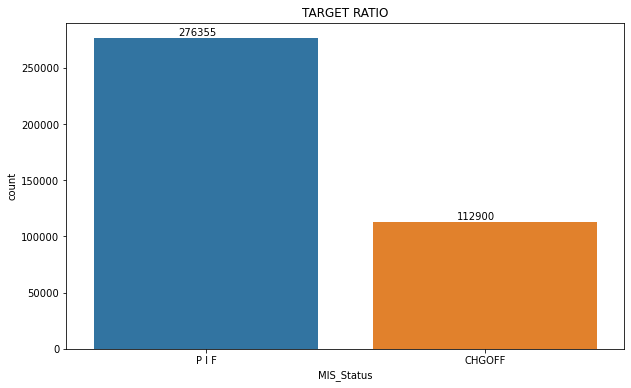

In [13]:
plt.figure(figsize=(10,6))
ax=sns.countplot(df['MIS_Status'])
plt.title('TARGET RATIO')
for i in ax.patches:
    ax.annotate('{}'.format(i.get_height()),(i.get_x()+0.3,i.get_height()+2000),color='black')


#### There are 276355 PIF - Fully Paid entries

#### There are 112900 CHGOFF - charged off entries

In [14]:
numerical = ['DisbursementGross','SBA_Appv','NoEmp','CreateJob','RetainedJob','Term','GrAppv']
categorical =['ApprovalFY','NewExist','FranchiseCode','UrbanRural','LowDoc']

In [15]:
class style:
#These are the ANSI escape sequences to set Graphics in our output
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   BLINK = '\033[5m'
   END = '\033[0m'

In [16]:
def univariate_analysis_categorical(cat, i):
    print(f"\t\t{style.BOLD}Univariate Analysis of {cat}")
    print(f"-----------------------------------------------------------{style.END}")
    print(f"{i+1}. No of unique values in {style.BOLD}{cat}{style.END} are: {df[cat].nunique()}. \nThe distribution is as follows:")
    print(f"{style.BOLD}{cat}{style.END}\n{df[cat].value_counts()}\n")
    vc = df[cat].value_counts()
    if len(vc.index)<=5:
        g = sns.countplot(x=cat, data=df, palette = 'pastel', order = df[cat].value_counts().index)
    elif len(vc.index)>5 and len(vc.index)<=15:
        g = sns.countplot(y=cat, data=df, palette = 'pastel', order = df[cat].value_counts().index)
    elif len(vc.index)>15:
        g = sns.countplot(x=cat, data=df, palette = 'pastel',order = df[cat].value_counts().index)
        g.set_xticklabels(labels = g.get_xticklabels(), rotation = 90)
    plt.show()
    print("\t")

		Univariate Analysis of ApprovalFY
-----------------------------------------------------------
1. No of unique values in ApprovalFY are: 11. 
The distribution is as follows:
ApprovalFY
2005    77525
2006    76040
2007    71876
2004    68290
2008    39540
2009    19126
2010    16848
2011    12608
2012     5997
2013     2458
2014      268
Name: ApprovalFY, dtype: int64



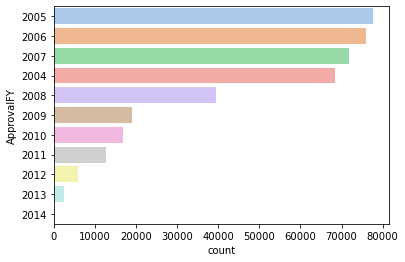

	
		Univariate Analysis of NewExist
-----------------------------------------------------------
2. No of unique values in NewExist are: 3. 
The distribution is as follows:
NewExist
1.0    274076
2.0    116199
0.0       165
Name: NewExist, dtype: int64



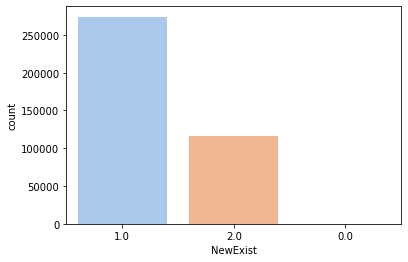

	
		Univariate Analysis of FranchiseCode
-----------------------------------------------------------
3. No of unique values in FranchiseCode are: 2. 
The distribution is as follows:
FranchiseCode
0    372491
1     18085
Name: FranchiseCode, dtype: int64



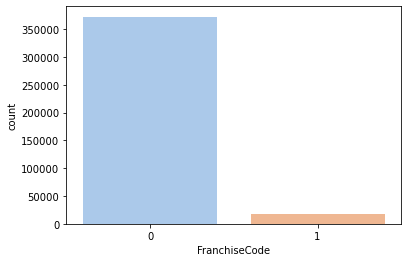

	
		Univariate Analysis of UrbanRural
-----------------------------------------------------------
4. No of unique values in UrbanRural are: 3. 
The distribution is as follows:
UrbanRural
1    312697
2     75001
0      2878
Name: UrbanRural, dtype: int64



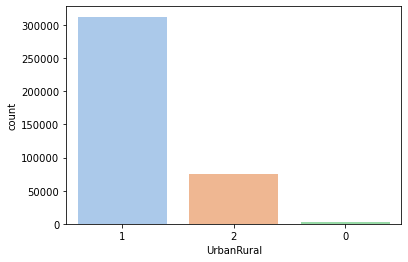

	
		Univariate Analysis of LowDoc
-----------------------------------------------------------
5. No of unique values in LowDoc are: 2. 
The distribution is as follows:
LowDoc
0    379830
1     10746
Name: LowDoc, dtype: int64



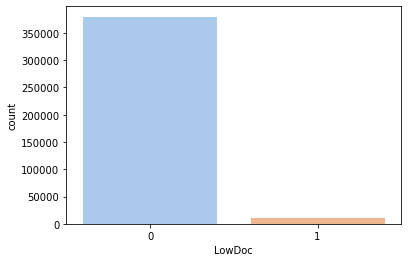

In [17]:
for i,x in enumerate(categorical):
        univariate_analysis_categorical(x, i) 

In [18]:
def univariate_analysis_numerical(num, i):
    print(f"\t\t{style.BOLD}Univariate Analysis of {num}")
    print(f"-----------------------------------------------------------{style.END}")
    print(f"{style.BOLD}{num}{style.END}\n")
    print(f"{style.BOLD}The distribution of {num} is as follows:")
    print(sns.boxplot(x=df[num]))
    plt.show()
    print(f"{style.BOLD}The distribution of {num} is as follows:")
    print(sns.distplot(x=df[num]))
    plt.show()
    print("\t")

		Univariate Analysis of DisbursementGross
-----------------------------------------------------------
DisbursementGross

The distribution of DisbursementGross is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


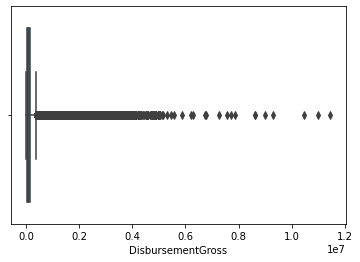

The distribution of DisbursementGross is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


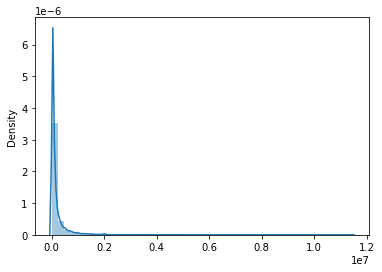

	
		Univariate Analysis of SBA_Appv
-----------------------------------------------------------
SBA_Appv

The distribution of SBA_Appv is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


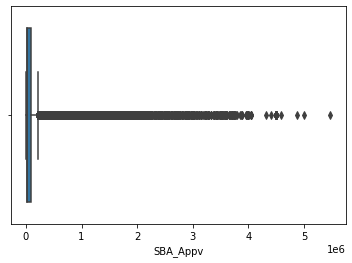

The distribution of SBA_Appv is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


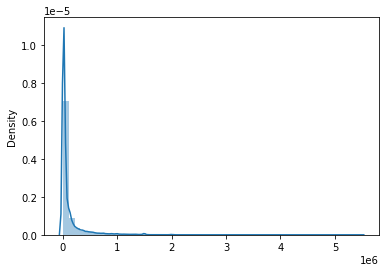

	
		Univariate Analysis of NoEmp
-----------------------------------------------------------
NoEmp

The distribution of NoEmp is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


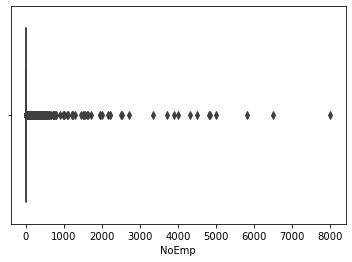

The distribution of NoEmp is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


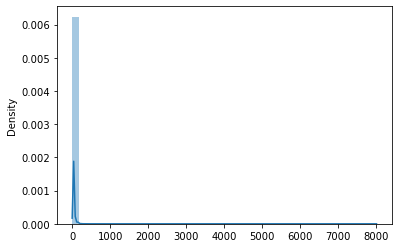

	
		Univariate Analysis of CreateJob
-----------------------------------------------------------
CreateJob

The distribution of CreateJob is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


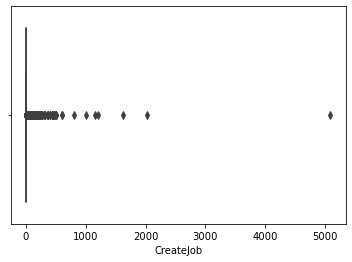

The distribution of CreateJob is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


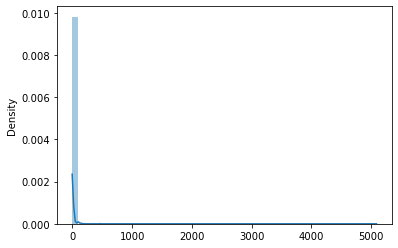

	
		Univariate Analysis of RetainedJob
-----------------------------------------------------------
RetainedJob

The distribution of RetainedJob is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


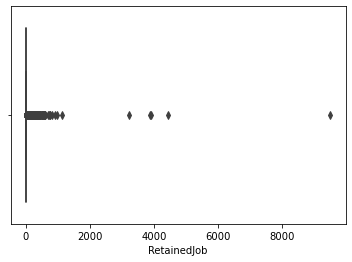

The distribution of RetainedJob is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


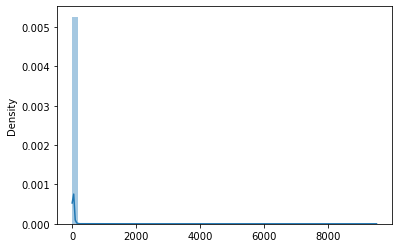

	
		Univariate Analysis of Term
-----------------------------------------------------------
Term

The distribution of Term is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


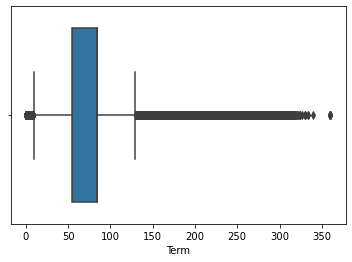

The distribution of Term is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


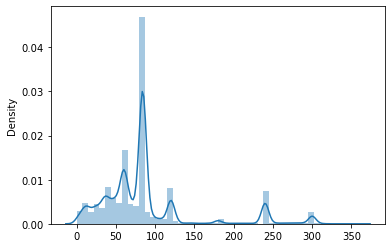

	
		Univariate Analysis of GrAppv
-----------------------------------------------------------
GrAppv

The distribution of GrAppv is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


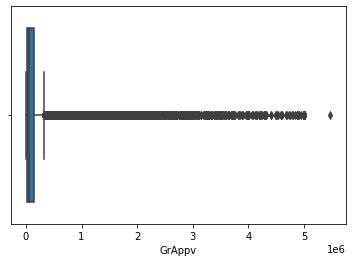

The distribution of GrAppv is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


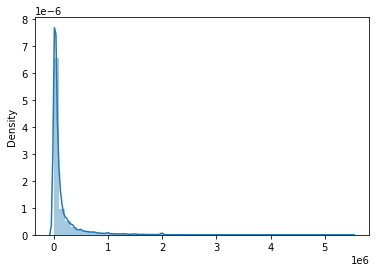

In [19]:
for i,x in enumerate(numerical):
        univariate_analysis_numerical(x, i) 

* We can see that DisbursementGross and GrAppv are highly right skewed and can have potential outliers on higher side.

* As it is Loan amount, this distribution is accepted.

# MISSING VALUE TREATMENT

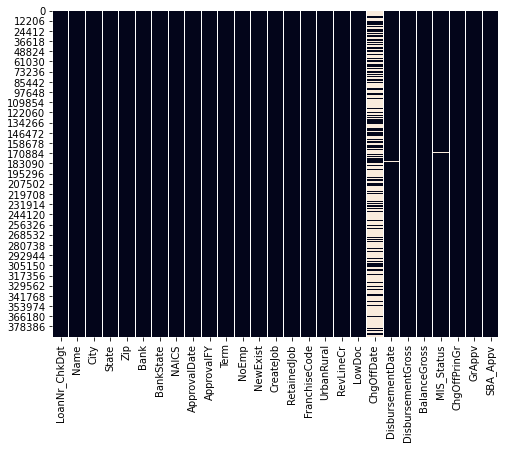

In [20]:
# Visualizing missing values
plt.figure(figsize=(8,6))
sns.heatmap(df.isna(),cbar=False)
plt.show()

In [21]:
Missing_values = pd.DataFrame({'Count':df.isnull().sum(),'Percentage':df.isnull().sum()/len(df)*100})
Missing_values.sort_values(by='Percentage',ascending=False)

,Count,Percentage
ChgOffDate,273984,70.148703
MIS_Status,1321,0.338218
DisbursementDate,1132,0.289828
RevLineCr,482,0.123407
NewExist,136,0.034820
Bank,12,0.003072
BankState,12,0.003072
Name,7,0.001792
LoanNr_ChkDgt,0,0.000000
UrbanRural,0,0.000000


* 'LoanNr_ChkDgt', 'City', 'State', 'Zip','NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp','CreateJob', 
'RetainedJob', 'FranchiseCode', 'UrbanRural', 'LowDoc',  'DisbursementGross','BalanceGross',  'GrAppv', 'SBA_Appv','ChgOffPrinGr'
#### Above columns doesn't have any missing values

* 'MIS_Status','ChgOffDate','Bank','BankState','NewExist','Name','DisbursementDate','RevLineCr
#### Above columns have missing values

In [22]:
Missing_values[Missing_values['Count']>0].sort_values(by='Percentage',ascending=False)

,Count,Percentage
ChgOffDate,273984,70.148703
MIS_Status,1321,0.338218
DisbursementDate,1132,0.289828
RevLineCr,482,0.123407
NewExist,136,0.034820
Bank,12,0.003072
BankState,12,0.003072
Name,7,0.001792


* Considering threshold as 10%, dropping those columns data whose missing values percentage is less than the threshold.

* MIS_Status being target column, can't be done any imputations, so dropping those missing records.

* 'Bank','BankState','NewExist','Name','RevLineCr' -- dropping these missing records

In [23]:
df.dropna(subset=['Bank','BankState','NewExist','Name','RevLineCr','MIS_Status'],inplace=True)

#### IMPUTING DisbursementDate Column

In [24]:
df['Date_Diff']= (df['DisbursementDate'] - df['ApprovalDate']).dt.days
print('Number of missing values in Date difference column :',df['Date_Diff'].isna().sum())

print('The skewness in Date difference column :',df['Date_Diff'].skew())

print('The mean of Date difference column :',df['Date_Diff'].mean())

print('The median of Date difference column :',df['Date_Diff'].median())


Number of missing values in Date difference column : 1105
The skewness in Date difference column : 5.27003878169898
The mean of Date difference column : 82.48142394487955
The median of Date difference column : 37.0


In [25]:
df[df['Date_Diff']<0][['ApprovalDate','DisbursementDate']]

,ApprovalDate,DisbursementDate
220056,2009-03-19,2009-03-16
226409,2009-06-10,2009-03-31
235409,2009-10-06,2009-10-05
235410,2009-10-06,2009-10-05
235412,2009-10-06,2009-10-05
...,...,...
258828,2011-03-04,2011-03-01
265145,2011-10-03,2011-10-01
265146,2011-10-03,2011-10-01
298612,2004-03-01,2002-07-08


* As per the given info, Disbursement  date cannot be before Apparoval date, hence considering these rows as entry errors.

* Assigning the negative date difference values to NAN, for appropriate imutations.

In [26]:
def imputing_nan(value):
    if value<0:
        return np.nan
    else:
        return value

Number of missing values in Date difference column : 1412


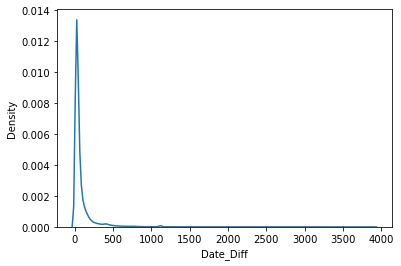

In [27]:
df['Date_Diff']=df['Date_Diff'].apply(imputing_nan)

print('Number of missing values in Date difference column :',df['Date_Diff'].isna().sum())

sns.distplot(df['Date_Diff'],hist=False)
plt.show()

In [28]:
df['Date_Diff'].describe()

count    387208.000000
mean         82.561047
std         150.759031
min           0.000000
25%          21.000000
50%          37.000000
75%          75.000000
max        3905.000000
Name: Date_Diff, dtype: float64

* There were certain loans where disbursements took quite some time even after approvals.

* As shown in above graph, the potential outliers are causing bacause of these delayed disbursements.

In [29]:
df['Date_Diff'] = df['Date_Diff'].fillna(df['Date_Diff'].median())

print('Number of missing values in Date difference column :',df['Date_Diff'].isna().sum())

Number of missing values in Date difference column : 0


* Considering skew into factor, imputing null values with median.

* As we have taken necessary information from DisbursementDate and ApprovalDate captured in new variable Date_Diff,
going forward we will be dropping these two variables.

* ChgOff data is generally recorded after granting the loans, so to predict whether the loan is approved or denied 
we would not require chgOff data, so going forward with the model building we will be dropping ChgffDate and ChgOffPrinGr.

#### NAICS

#### Sector	Description
* 11-Agriculture, forestry, fishing and hunting
* 21-Mining, quarrying, and oil and gas extraction
* 22-Utilities
* 23-Construction
* 31-33-Manufacturing
* 42-Wholesale trade
* 44–45-Retail trade
* 48–49-Transportation and warehousing
* 51-Information
* 52-Finance and insurance
* 53-Real estate and rental and leasing
* 54-Professional, scientific, and technical services
* 55-Management of companies and enterprises
* 56-Administrative and support and waste management and remediation services
* 61-Educational services
* 62-Health care and social assistance
* 71-Arts, entertainment, and recreation
* 72-Accommodation and food services
* 81-Other services (except public administration) 92 Public administration

In [30]:
def extracting_codes(value):
    temp = str(value)
    if(temp[:2] == '31') | (temp[:2] == '32') | (temp[:2] == '33'):
             return '31-33'
    elif(temp[:2] == '44') | (temp[:2] == '45'):
            return '44-45'
    elif(temp[:2] == '48') | (temp[:2] == '49'):
            return '48-49'
    else:
            return temp[:2]

In [31]:
df['NAICS']=df['NAICS'].apply(extracting_codes)

In [32]:
df['NAICS'].value_counts().sort_index()

0            6
11        2966
21         863
22         320
23       41029
31-33    32083
42       24433
44-45    66963
48-49    16603
51        7128
52        6933
53        9364
54       40999
55          84
56       21434
61        4632
62       26388
71        7957
72       42119
81       36233
92          83
Name: NAICS, dtype: int64

* As per the given sectors extracted first two digits and bucktized the data.

* Identified entries such as 0,92 where they don't belong to any of the given sector, so dropping those records.

In [33]:
df = df[(df['NAICS']!='0') & (df['NAICS']!='92')]

In [34]:
df['NAICS'].value_counts().sort_index()

11        2966
21         863
22         320
23       41029
31-33    32083
42       24433
44-45    66963
48-49    16603
51        7128
52        6933
53        9364
54       40999
55          84
56       21434
61        4632
62       26388
71        7957
72       42119
81       36233
Name: NAICS, dtype: int64

In [35]:
# Cleaning the NewExist Column

print(df['NewExist'].value_counts())
print('\n')
df = df[df['NewExist']!= 0]

print(df['NewExist'].value_counts())

1.0    272671
2.0    115695
0.0       165
Name: NewExist, dtype: int64


1.0    272671
2.0    115695
Name: NewExist, dtype: int64


* As per the data dictionary NewExist feature can only have 1(Existing Business) or 2(New Business)
* Dropping such entries where NewExist is not equal to 1 or 2.

In [36]:
# Creating a new column RealEstate

def new_col(value):
    if value>=240:
        return 1
    else:
        return 0

In [37]:
df['RealEstate'] = df['Term'].map(new_col)
df['RealEstate'].value_counts()

0    356334
1     32032
Name: RealEstate, dtype: int64

* Based on term we are creating a new variable RealEstate

* If the Term of the loan is greater than or equal to 240 months then the loan is backed up by RealEstate classified it as 1.

* If the Term of the loan is less than 240 months then the loan is not backed up by RealEstate classified it as 0.

#### Imputing the Missing Values - RevLineCr

In [38]:
df['RevLineCr'].value_counts()

Y    152037
N    126947
0     98579
T     10796
R         3
1         3
A         1
Name: RevLineCr, dtype: int64

* RevlineCr can only have Y|N values, but observing some entry errors.
* Replacing these entry errors with mode can be a biased decision.
* We will be classifying these entry erros as Y|N by applying classification model.
* Assiging  all the entry errors with NAN initially to run an classification model.
* Applying Extratree classifier over dataset in order to predict missing values of RevLineCr.

In [39]:
df_imputation = df.copy()

df_imputation.drop(['LoanNr_ChkDgt','Name','City','State','Zip','Bank','BankState','ApprovalDate','ApprovalFY','ChgOffDate','DisbursementDate','ChgOffPrinGr','DisbursementGross','BalanceGross'],axis=1,inplace=True)

df_imputation.head(2)

,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv,Date_Diff,RealEstate
0,44-45,162,2,2.0,0,0,1,1,N,0,P I F,253400.0,190050.0,52.0,0
1,72,126,7,1.0,0,0,0,1,N,0,P I F,137300.0,116705.0,82.0,0


In [40]:
df_imputation = df_imputation[(df_imputation['RevLineCr']!='R') & (df_imputation['RevLineCr']!='1') & (df_imputation['RevLineCr']!='A')]

In [41]:
print('Value counts for RevLineCr:',df_imputation['RevLineCr'].value_counts())
print('\n')
df_imputation['RevLineCr'] = df_imputation['RevLineCr'].replace({'0':np.nan,'T':np.nan})

print('No.of Missing values in RevLineCr:', df_imputation['RevLineCr'].isna().sum())
print('\n')
# Dropping the entry error value in UrbanRural
df_imputation = df_imputation[(df_imputation['UrbanRural']!=0)]
print('Value counts for UrbanRural after dropping entry error:',df_imputation['UrbanRural'].value_counts())

Value counts for RevLineCr: Y    152037
N    126947
0     98579
T     10796
Name: RevLineCr, dtype: int64


No.of Missing values in RevLineCr: 109375


Value counts for UrbanRural after dropping entry error: 1    310975
2     74518
Name: UrbanRural, dtype: int64


In [42]:
df_encode = pd.get_dummies(df_imputation.drop('RevLineCr',axis=1),drop_first=True)
df_encode.head(3)

,Term,NoEmp,CreateJob,RetainedJob,GrAppv,SBA_Appv,Date_Diff,RealEstate,NAICS_21,NAICS_22,...,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NewExist_2.0,FranchiseCode_1,UrbanRural_2,LowDoc_1,MIS_Status_P I F
0,162,2,0,0,253400.0,190050.0,52.0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,126,7,0,0,137300.0,116705.0,82.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,83,18,5,23,100000.0,50000.0,21.0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [43]:
df_encode['RevLineCr'] = df_imputation['RevLineCr']

X = df_encode[(df_encode['RevLineCr']=='Y') | (df_encode['RevLineCr']=='N')]

x_test = df_encode[~((df_encode['RevLineCr']=='Y') | (df_encode['RevLineCr']=='N'))]

y_train = X.RevLineCr

x_train = X.drop('RevLineCr',1)
x_test = x_test.drop('RevLineCr',1)

print('The shape of y train data :',y_train.shape)
print('The shape of x train data :',x_train.shape)
print('The shape of x test data :',x_test.shape)

The shape of y train data : (278492,)
The shape of x train data : (278492, 31)
The shape of x test data : (107001, 31)


In [44]:
# Model Building 
# ExtraTreeClassifer Model

ex = ExtraTreeClassifier()
model_ex = ex.fit(x_train,y_train)
pred_ex = model_ex.predict(x_test)

#KNN Model

knn = KNeighborsClassifier(n_neighbors=5)
model_knn = knn.fit(x_train,y_train)
pred_knn = model_knn.predict(x_test)

In [45]:
Y_test_extra_tree = pd.DataFrame({'Y':pred_ex})
Y_test_extra_tree.Y.value_counts()

N    80543
Y    26458
Name: Y, dtype: int64

* The above are the predicted classes by applying Extratree classifier.

In [46]:
Y_test_KNN = pd.DataFrame({'Y':pred_knn})
Y_test_KNN.Y.value_counts()

N    84622
Y    22379
Name: Y, dtype: int64

* The above are the predicted classes by applying KNN classifier

* Noticed both the model predictions are of same proportion

* Going ahead with Extratree classifer output. 

In [47]:
x_test['RevLineCr'] = pred_ex

x_train['RevLineCr'] = y_train

df_new = pd.concat([x_train,x_test])
df_new.head()

,Term,NoEmp,CreateJob,RetainedJob,GrAppv,SBA_Appv,Date_Diff,RealEstate,NAICS_21,NAICS_22,...,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NewExist_2.0,FranchiseCode_1,UrbanRural_2,LowDoc_1,MIS_Status_P I F,RevLineCr
0,162,2,0,0,253400.0,190050.0,52.0,0,0,0,...,0,0,0,0,1,1,0,0,1,N
1,126,7,0,0,137300.0,116705.0,82.0,0,0,0,...,0,0,1,0,0,0,0,0,1,N
2,83,18,5,23,100000.0,50000.0,21.0,0,0,0,...,0,0,0,0,1,0,0,0,1,Y
3,84,4,0,4,35000.0,17500.0,21.0,0,0,0,...,0,0,0,0,0,0,0,0,1,Y
4,60,3,0,0,50000.0,42500.0,113.0,0,0,0,...,0,0,0,0,0,0,0,0,1,N


In [48]:
df_naics = df.groupby('NAICS')[['GrAppv','SBA_Appv']].mean()
df_naics=df_naics.reset_index()
df_naics

,NAICS,GrAppv,SBA_Appv
0,11,226413.457799,176895.465901
1,21,255849.284223,190023.099768
2,22,140085.018750,95778.003125
3,23,105719.727847,73453.452646
4,31-33,239577.321812,186648.903918
5,42,200999.316408,152502.919618
6,44-45,146538.829942,108778.624104
7,48-49,94921.321687,66799.290000
8,51,114733.257508,83365.238423
9,52,115727.282355,86627.198240


In [49]:
li=[]
for i,j in df_naics.iterrows():
    li.append((j['SBA_Appv']/j['GrAppv'])*100)
    
df_naics['Percentage']=li

df_naics

,NAICS,GrAppv,SBA_Appv,Percentage
0,11,226413.457799,176895.465901,78.129395
1,21,255849.284223,190023.099768,74.271499
2,22,140085.018750,95778.003125,68.371339
3,23,105719.727847,73453.452646,69.479419
4,31-33,239577.321812,186648.903918,77.907584
5,42,200999.316408,152502.919618,75.872357
6,44-45,146538.829942,108778.624104,74.231945
7,48-49,94921.321687,66799.290000,70.373325
8,51,114733.257508,83365.238423,72.660047
9,52,115727.282355,86627.198240,74.854603


Inference:

    -- The average amount backed up by SBA sector wise has shown in df_naics.
    -- The extarcted Percentage is the percentage of risk ceeded to SBA in case unforseen uncertainities. 

# OUTLIERS

In [50]:
# Number of outliers
def outlier_check(data,n):
    for col in data.columns:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_range= Q1-(n * IQR)
            upper_range= Q3+(n * IQR)
            print(f"{style.BOLD}{col}{style.END}")
            print("Number of outliers:",data[(data[col] > upper_range) | (data[col] < lower_range)].shape[0])
            print("Percentage of outliers:{0:10.3f}".format(((data[(data[col] > upper_range) | (data[col] < lower_range)].shape[0])/data.shape[0])*100),"%\n")

In [51]:
outlier_check(df, 1.5)

LoanNr_ChkDgt
Number of outliers: 0
Percentage of outliers:     0.000 %

Zip
Number of outliers: 0
Percentage of outliers:     0.000 %

ApprovalFY
Number of outliers: 20800
Percentage of outliers:     5.356 %

Term
Number of outliers: 48705
Percentage of outliers:    12.541 %

NoEmp
Number of outliers: 46580
Percentage of outliers:    11.994 %

CreateJob
Number of outliers: 36616
Percentage of outliers:     9.428 %

RetainedJob
Number of outliers: 39091
Percentage of outliers:    10.066 %

DisbursementGross
Number of outliers: 45905
Percentage of outliers:    11.820 %

BalanceGross
Number of outliers: 12
Percentage of outliers:     0.003 %

ChgOffPrinGr
Number of outliers: 66793
Percentage of outliers:    17.198 %

GrAppv
Number of outliers: 48364
Percentage of outliers:    12.453 %

SBA_Appv
Number of outliers: 52407
Percentage of outliers:    13.494 %

Date_Diff
Number of outliers: 45077
Percentage of outliers:    11.607 %

RealEstate
Number of outliers: 32032
Percentage of outliers:

# BIVARIATE ANALYSIS

#### NAICS 

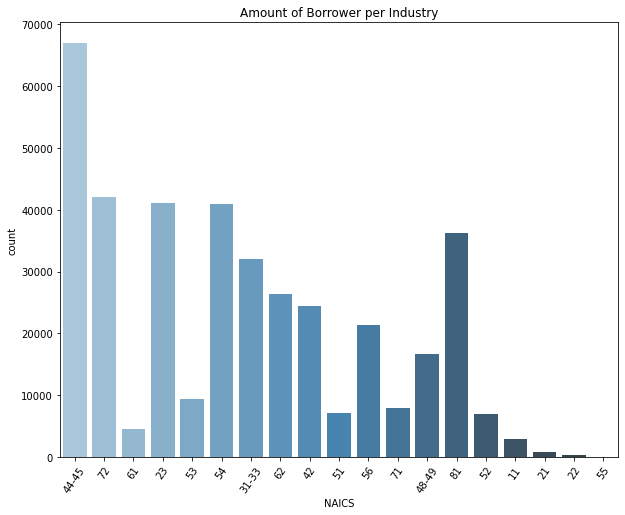

In [52]:
plt.figure(figsize=(10,8))
sns.countplot(df.NAICS,palette="Blues_d")
plt.title('Amount of Borrower per Industry')
plt.xticks(rotation=55)
plt.show()

In [53]:
df.NAICS.value_counts()

44-45    66936
72       42087
23       41021
54       40993
81       36220
31-33    32056
62       26377
42       24421
56       21426
48-49    16600
53        9362
71        7951
51        7126
52        6931
61        4631
11        2962
21         862
22         320
55          84
Name: NAICS, dtype: int64

* Above graph depicts the count of approved loans with respect to each sectors.

* We see that '44-45' [Retail trade sector has the Maximum count] , i.e more loans are being approved for this sector.

* Sector '55' [Management of companies and enterprises] is with the least count , i.e very less number of loans are being granted to this sector.

#### NAICS with MIS_Status

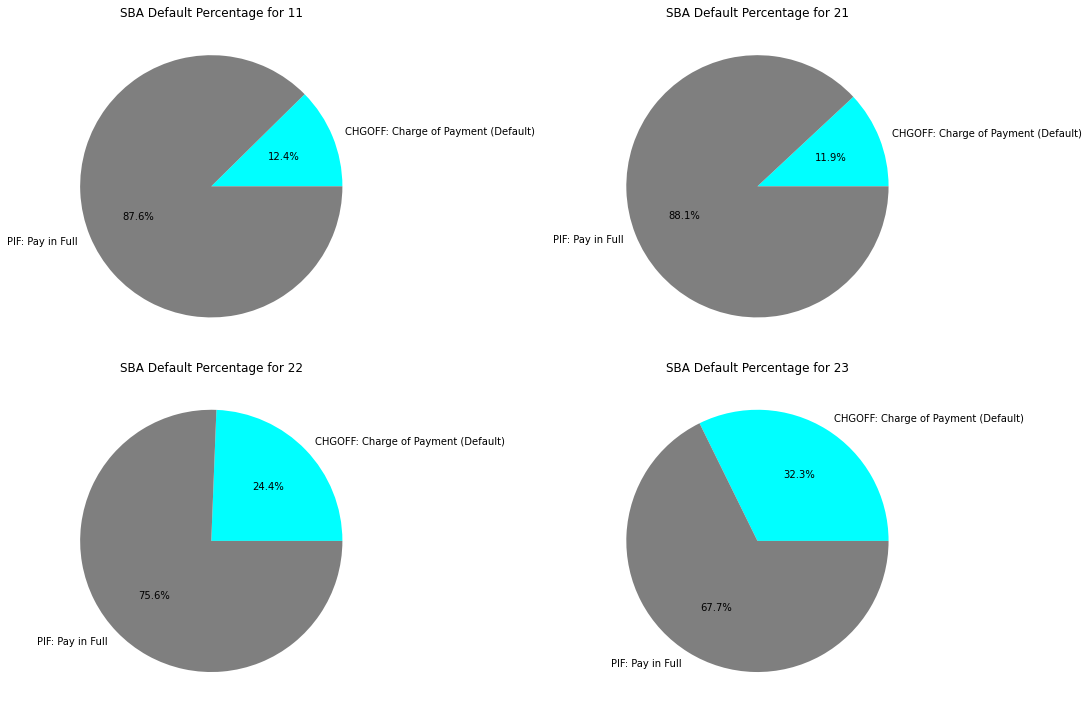

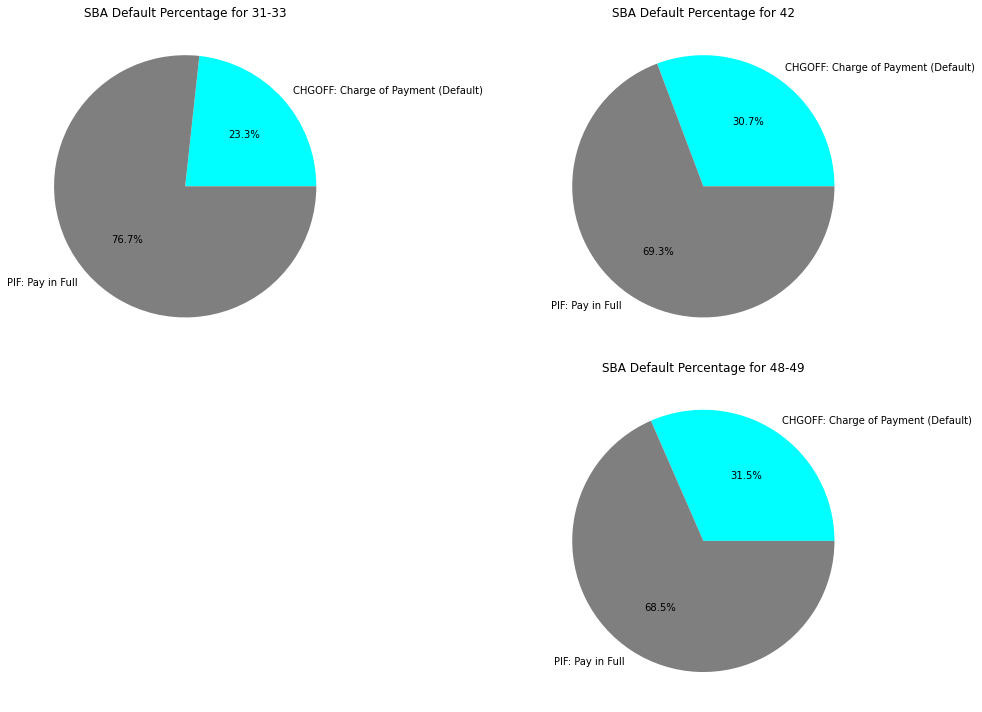

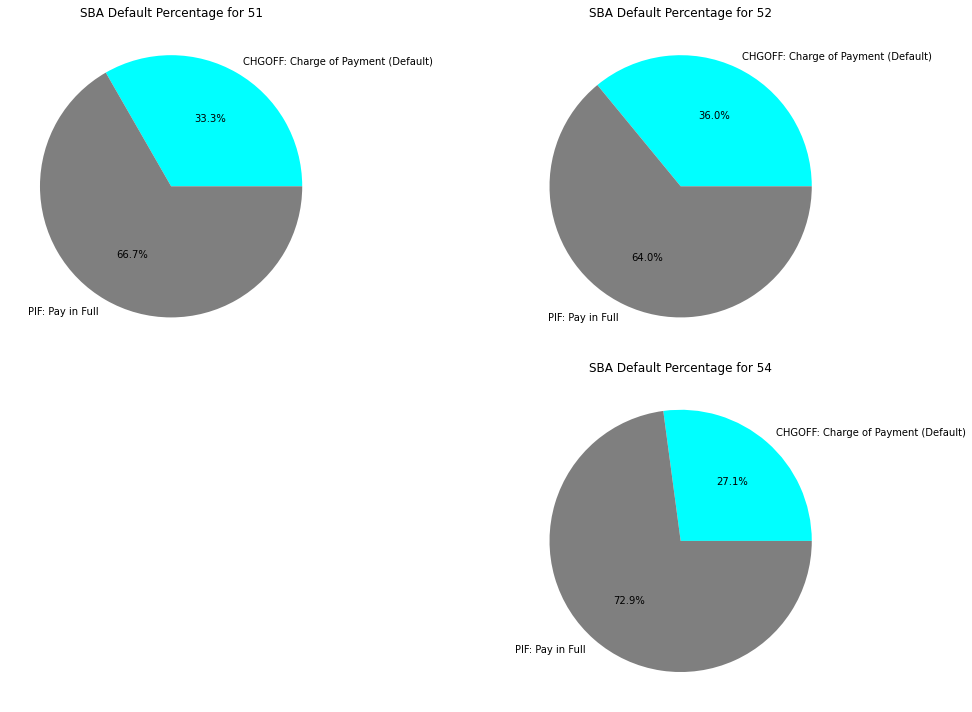

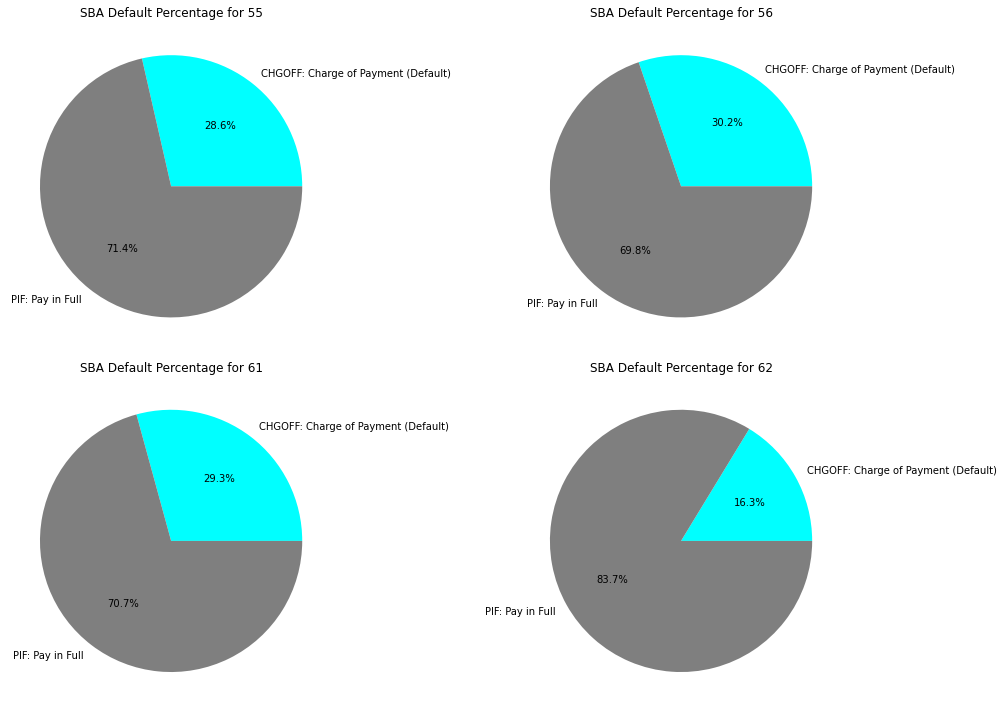

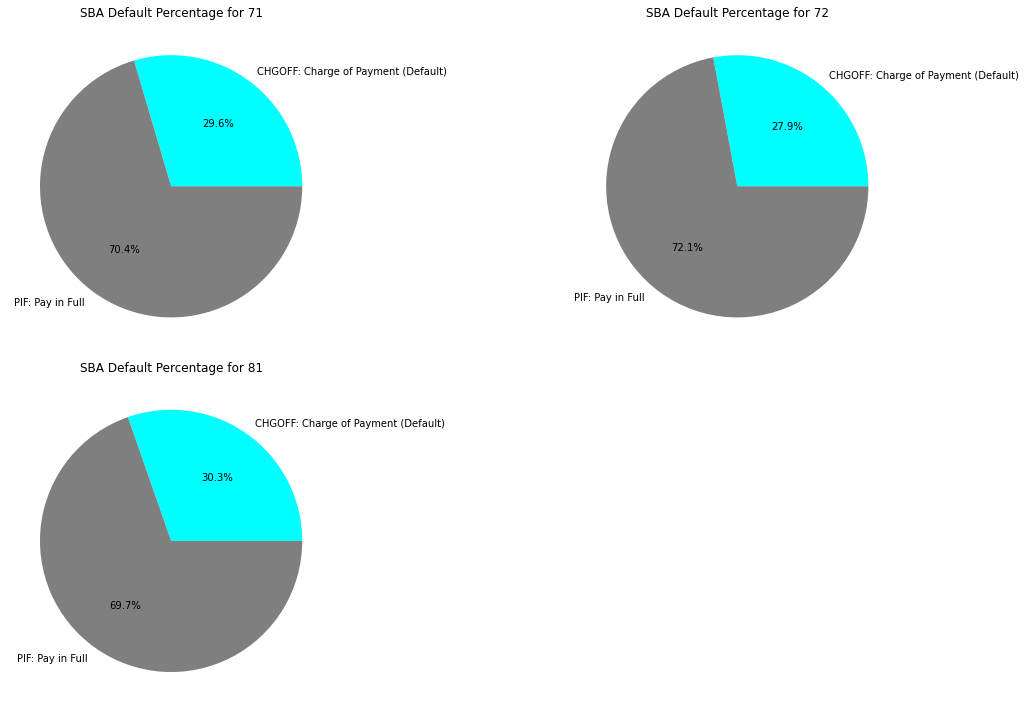

In [54]:
NAICS1= df_naics.groupby('NAICS').count()
x = 0
y = 221    
for i in NAICS1.index:
    if (x % 4) == 0:
        plt.figure(figsize=(16,10))
        y=221
        plt.subplot(y)
        y+=1
    else:
        plt.subplot(y)
        y+=1
    pieSBA = df[df.NAICS==i].groupby('MIS_Status').count()
    values = pieSBA['LoanNr_ChkDgt']
    labels = ['CHGOFF: Charge of Payment (Default)', 'PIF: Pay in Full']
    plt.pie(values,labels=labels, autopct='%1.1f%%',colors=['cyan','C7'])
    plt.title(f'SBA Default Percentage for {i}')
    plt.tight_layout()
    plt.show
    x+=1

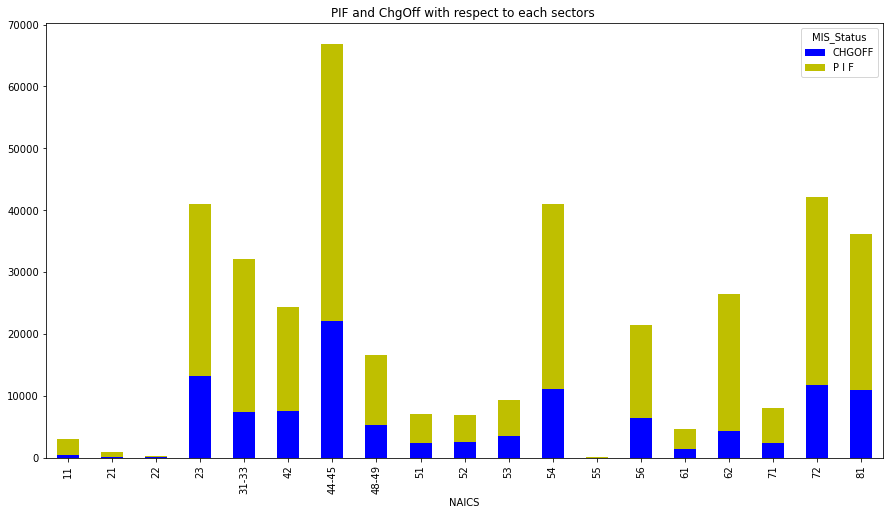

In [55]:
pd.crosstab(df['NAICS'],df['MIS_Status']).plot(kind='bar',stacked=True,figsize=(15,8),color='by')
plt.title('PIF and ChgOff with respect to each sectors ')
plt.show()

#### Sector with the highest Gross amount of loan

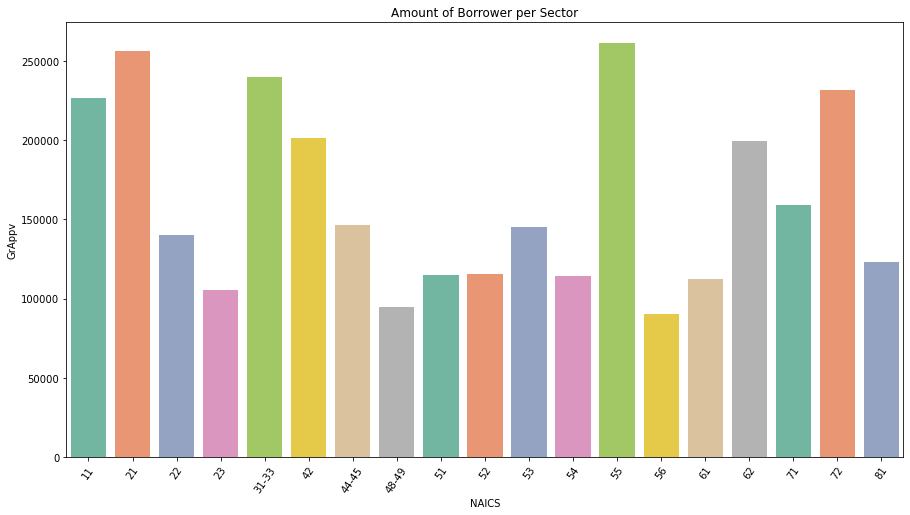

In [56]:
NAICS2 = df.groupby('NAICS').mean()
plt.figure(figsize=(15,8))
ax=sns.barplot(x=NAICS2.index , y=NAICS2['GrAppv'],palette="Set2")
plt.title('Amount of Borrower per Sector')
plt.xticks(rotation=55)
plt.show()

* Sector 55 and 21 have highest gross amount
* The total Gross amount sanctioned for sector 56 and 44-45 is less when compared with other sectors.
* Sector 55 having the least number of approved loan applications ,still it stands out to be the highest Gross amount.

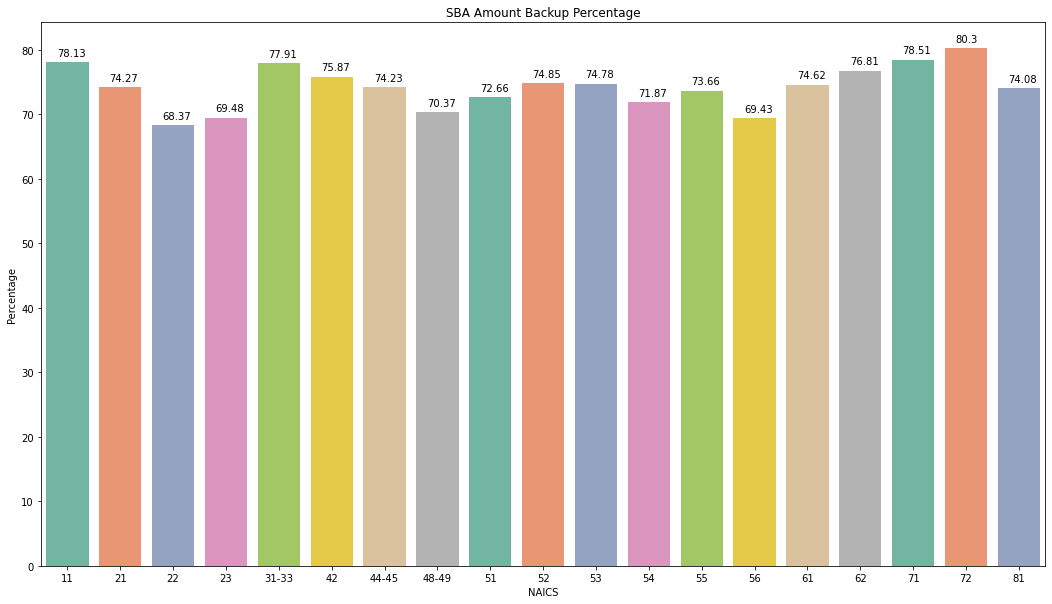

In [57]:
plt.figure(figsize=(18,10))
ax=sns.barplot(x=df_naics['NAICS'],y=round(df_naics['Percentage'],2),data=df_naics,palette='Set2')
plt.title('SBA Amount Backup Percentage')
for i in ax.patches:
    ax.annotate('{}'.format(i.get_height()),(i.get_x()+0.2,i.get_height()+1),color='black')


* Percentage of backed up amount by SBA is ranging between 70-80%.
* Sector 72 (Accommodation and Food Services) being the safest as it is bagging 80% of the backed up amount.

#### NewExist with MIS_Status

MIS_Status     CHGOFF      P I F
NewExist                        
1.0         29.318116  70.681884
2.0         28.429924  71.570076


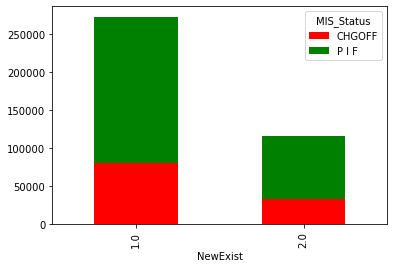

In [58]:
print(pd.crosstab(df['NewExist'],df['MIS_Status'],normalize='index')*100)
pd.crosstab(df['NewExist'],df['MIS_Status']).plot(kind='bar',stacked=True,color='rg')
plt.show()

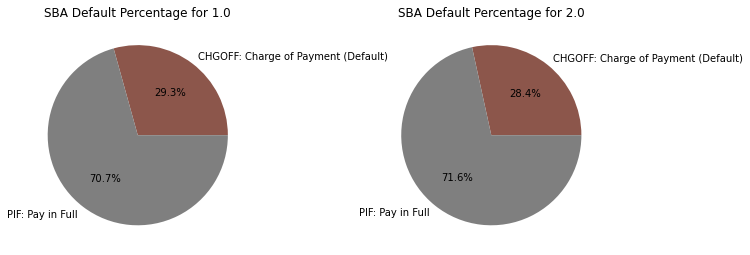

In [59]:
x = 0
y = 221    
for i in df[(df.NewExist == 1) | (df.NewExist == 2)].groupby('NewExist').count().index:
    if (x % 4) == 0:
        plt.figure(figsize=(10,8))
        y=221
        plt.subplot(y)
        y+=1
    else:
        plt.subplot(y)
        y+=1
    pieSBA = df[df.NewExist==i].groupby('MIS_Status').count()
    values = pieSBA['LoanNr_ChkDgt']
    labels = ['CHGOFF: Charge of Payment (Default)', 'PIF: Pay in Full']
    plt.pie(values, labels = labels, autopct='%1.1f%%',colors=['C5','C7'])
    plt.title(f'SBA Default Percentage for {i}')
    plt.tight_layout()
    plt.show
    x+=1

* 1 = Exisiting Business

* 2 = New Business

#### UrbanRural with MIS_Status

MIS_Status     CHGOFF      P I F
UrbanRural                      
0           33.077460  66.922540
1           30.780857  69.219143
2           21.690530  78.309470


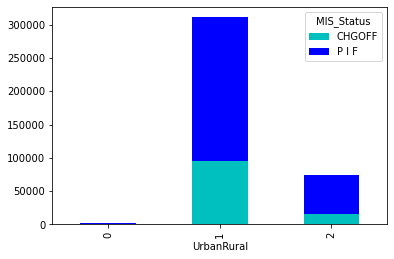

In [60]:
print(pd.crosstab(df['UrbanRural'],df['MIS_Status'],normalize='index')*100)
pd.crosstab(df['UrbanRural'],df['MIS_Status']).plot(kind='bar',stacked=True,color='cb')
plt.show()

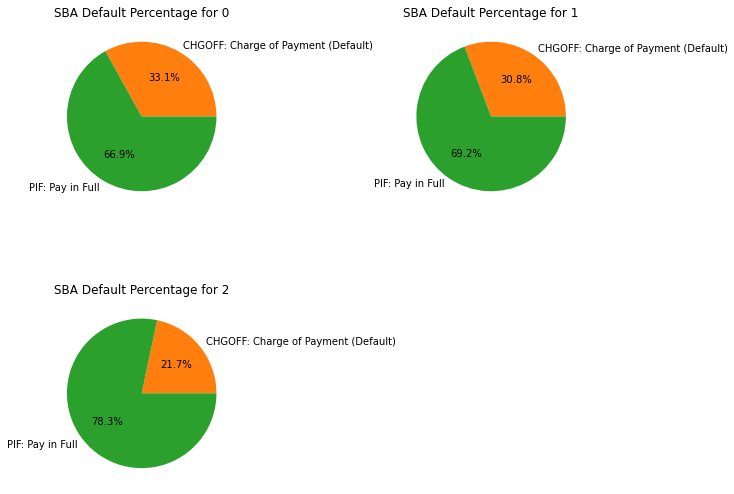

In [61]:
x = 0
y = 221    
for i in df[(df.UrbanRural == 0) | (df.UrbanRural == 1) | (df.UrbanRural == 2)].groupby('UrbanRural').count().index:
    if (x % 4) == 0:
        plt.figure(figsize=(10,8))
        y=221
        plt.subplot(y)
        y+=1
    else:
        plt.subplot(y)
        y+=1
    pieSBA = df[df.UrbanRural==i].groupby('MIS_Status').count()
    values = pieSBA['LoanNr_ChkDgt']
    labels = ['CHGOFF: Charge of Payment (Default)', 'PIF: Pay in Full']
    plt.pie(values, labels = labels, autopct='%1.1f%%',colors=['C11','C12'])
    plt.title(f'SBA Default Percentage for {i}')
    plt.tight_layout()
    plt.show
    x+=1

* 1 = Urban
* 2 = Rural
* 0 = Undefined

#### LowDoc with MIS_Status

MIS_Status     CHGOFF      P I F
LowDoc                          
0           29.382013  70.617987
1           17.500233  82.499767


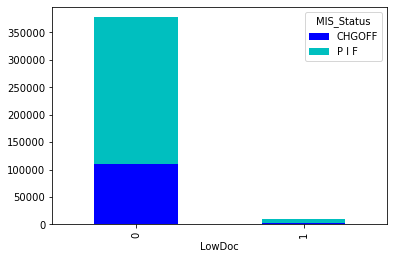

In [62]:
print(pd.crosstab(df['LowDoc'],df['MIS_Status'],normalize='index')*100)
pd.crosstab(df['LowDoc'],df['MIS_Status']).plot(kind='bar',stacked=True,color='bc')
plt.show()

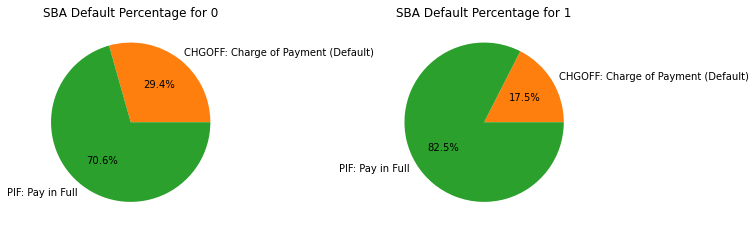

In [63]:
x = 0
y = 221    
for i in df.groupby('LowDoc').count().index:
    if (x % 4) == 0:
        plt.figure(figsize=(10,8))
        y=221
        plt.subplot(y)
        y+=1
    else:
        plt.subplot(y)
        y+=1
    pieSBA = df[df.LowDoc==i].groupby('MIS_Status').count()
    values = pieSBA['LoanNr_ChkDgt']
    labels = ['CHGOFF: Charge of Payment (Default)', 'PIF: Pay in Full']
    plt.pie(values, labels = labels, autopct='%1.1f%%',colors=['C11','C12'])
    plt.title(f'SBA Default Percentage for {i}')
    plt.tight_layout()
    plt.show
    x+=1

* 1 = Yes

* 0 = No

#### RealEstate with MIS_Status

MIS_Status     CHGOFF      P I F
RealEstate                      
0           31.392738  68.607262
1            3.031344  96.968656


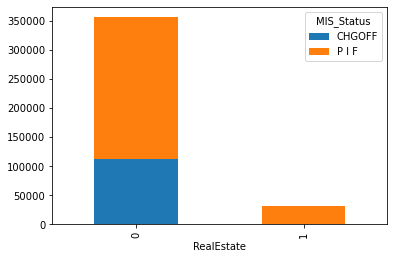

In [64]:
print(pd.crosstab(df['RealEstate'],df['MIS_Status'],normalize='index')*100)
pd.crosstab(df['RealEstate'],df['MIS_Status']).plot(kind='bar',stacked=True)
plt.show()

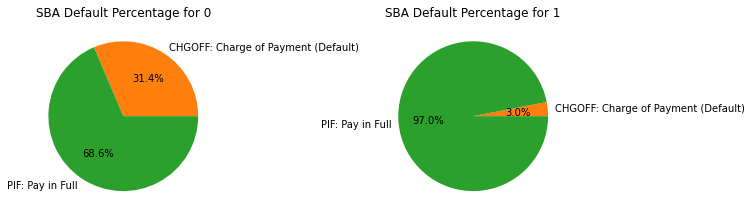

In [65]:
x = 0
y = 221    
for i in df.groupby('RealEstate').count().index:
    if (x % 4) == 0:
        plt.figure(figsize=(10,8))
        y=221
        plt.subplot(y)
        y+=1
    else:
        plt.subplot(y)
        y+=1
    pieSBA = df[df.RealEstate==i].groupby('MIS_Status').count()
    values = pieSBA['LoanNr_ChkDgt']
    labels = ['CHGOFF: Charge of Payment (Default)', 'PIF: Pay in Full']
    plt.pie(values, labels = labels, autopct='%1.1f%%',colors=['C11','C12'])
    plt.title(f'SBA Default Percentage for {i}')
    plt.tight_layout()
    plt.show
    x+=1

* 1 = Backed up by RealEstate

* 0 = Not Backed up by RealEstate

#### FranchiseCode with MIS_Status

MIS_Status        CHGOFF      P I F
FranchiseCode                      
0              29.325428  70.674572
1              23.458162  76.541838


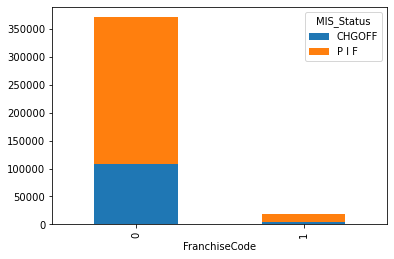

In [66]:
print(pd.crosstab(df['FranchiseCode'],df['MIS_Status'],normalize='index')*100)
pd.crosstab(df['FranchiseCode'],df['MIS_Status']).plot(kind='bar',stacked=True)
plt.show()

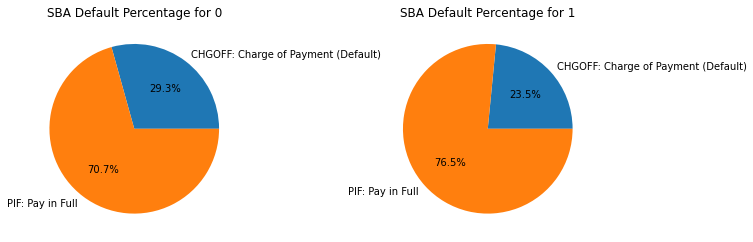

In [67]:
x = 0
y = 221    
for i in df.groupby('FranchiseCode').count().index:
    if (x % 4) == 0:
        plt.figure(figsize=(10,8))
        y=221
        plt.subplot(y)
        y+=1
    else:
        plt.subplot(y)
        y+=1
    pieSBA = df[df.FranchiseCode==i].groupby('MIS_Status').count()
    values = pieSBA['LoanNr_ChkDgt']
    labels = ['CHGOFF: Charge of Payment (Default)', 'PIF: Pay in Full']
    plt.pie(values, labels = labels, autopct='%1.1f%%')
    plt.title(f'SBA Default Percentage for {i}')
    plt.tight_layout()
    plt.show
    x+=1

* 1 = Companies having franchise

* 0 = Companies not having franchise

#### RevLineCr with MIS_Status

MIS_Status     CHGOFF      P I F
RevLineCr                       
N           27.980983  72.019017
Y           30.237794  69.762206


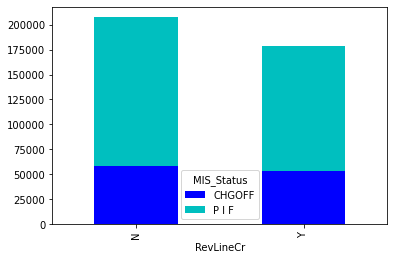

In [68]:
print(pd.crosstab(df_new['RevLineCr'],df['MIS_Status'],normalize='index')*100)
pd.crosstab(df_new['RevLineCr'],df['MIS_Status']).plot(kind='bar',stacked=True,color='bc')
plt.show()

#### New Jobs Created

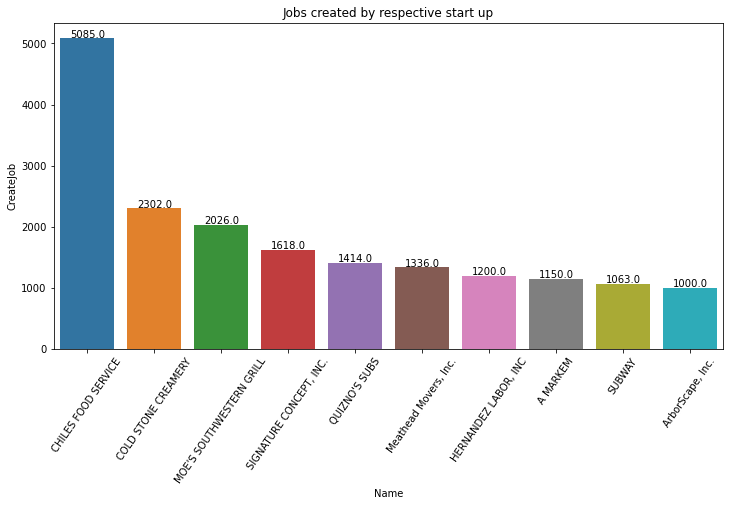

In [69]:
new_job = df.groupby('Name')[['CreateJob']].sum().sort_values(by='CreateJob',ascending=False)
new_job1 = new_job.reset_index().head(10)
plt.figure(figsize=(12,6))
ax = sns.barplot(new_job1['Name'],new_job1['CreateJob'])
plt.title('Jobs created by respective start up')
plt.xticks(rotation=55)
for i in ax.patches:
    ax.annotate('{}'.format(i.get_height()),(i.get_x()+0.15,i.get_height()+20),color='black')
plt.show()

* Above are the Top 10 business organisations creating new jobs.

#### Correlation

                   DisbursementGross  SBA_Appv     NoEmp  CreateJob  \
DisbursementGross           1.000000  0.930059  0.147032   0.113017   
SBA_Appv                    0.930059  1.000000  0.143092   0.125401   
NoEmp                       0.147032  0.143092  1.000000   0.085139   
CreateJob                   0.113017  0.125401  0.085139   1.000000   
RetainedJob                 0.119418  0.099446  0.256865   0.066985   
Term                        0.479693  0.555985  0.057317   0.075883   
GrAppv                      0.954525  0.985365  0.145510   0.117377   

                   RetainedJob      Term    GrAppv  
DisbursementGross     0.119418  0.479693  0.954525  
SBA_Appv              0.099446  0.555985  0.985365  
NoEmp                 0.256865  0.057317  0.145510  
CreateJob             0.066985  0.075883  0.117377  
RetainedJob           1.000000  0.019628  0.111737  
Term                  0.019628  1.000000  0.535161  
GrAppv                0.111737  0.535161  1.000000  




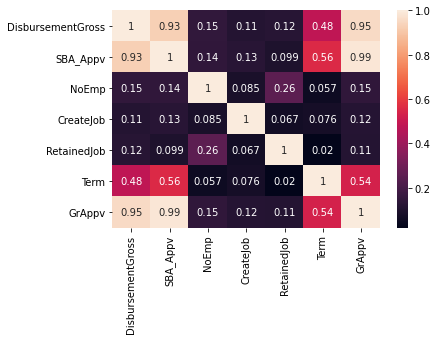

In [70]:
numerical_corr = df[['DisbursementGross','SBA_Appv','NoEmp','CreateJob','RetainedJob','Term','GrAppv']]

print(numerical_corr.corr())
print('\n')
sns.heatmap(numerical_corr.corr(),annot=True)
plt.show()

* As observed above correlation plot, There is a strong proitive correlation between SBA_Appv and GrAppv
This is valid as SBA_Apprv is depend on GrAppv with some proporation based on sector
* Similar way GrAppv with DisbursementGross
* While building a model we are dropping such features which are providing redundant information.

# STATISTICAL TESTS

#### Performing statistical tests on each attributes with respect to target column.

#### Hypothesis for Chi2_contingency Tests

#### 𝐻0 : The variables are independent

#### 𝐻1: The variables are not independent (i.e. variables are dependent)

In [71]:
columns_tests =['NewExist','FranchiseCode','UrbanRural','LowDoc','NAICS','State','Bank','BankState','City']
Test_results =[]
for i in columns_tests:
    p_value = chi2_contingency(observed=pd.crosstab(df[i],df['MIS_Status']).values,correction=False)[1]
    Test_results.append(p_value)
    
    
Results = pd.DataFrame({'Features':columns_tests ,'P value':Test_results})

Results

,Features,P value
0,NewExist,2.465539e-08
1,FranchiseCode,2.664278e-64
2,UrbanRural,0.000000e+00
3,LowDoc,1.590686e-157
4,NAICS,0.000000e+00
5,State,0.000000e+00
6,Bank,0.000000e+00
7,BankState,0.000000e+00
8,City,0.000000e+00


* All the columns have p_value less than 0.05 we reject null hyothesis and can conclude all these columns has an ability to explain target column MIS_Status

#### Normality Test

#### HYPOTHESIS

#### H0: The data is normally distributed

#### H1: The data is not normally distributed

In [72]:
columns_tests =['Term','Date_Diff','SBA_Appv','GrAppv','NoEmp','CreateJob','RetainedJob','DisbursementGross']
pval=[]
for i in columns_tests:
    stat, p_value = stats.shapiro(df[i])
    pval.append(p_value)
    
Results = pd.DataFrame({'Features':columns_tests ,'P value':pval})

Results

,Features,P value
0,Term,0.0
1,Date_Diff,0.0
2,SBA_Appv,0.0
3,GrAppv,0.0
4,NoEmp,0.0
5,CreateJob,0.0
6,RetainedJob,0.0
7,DisbursementGross,0.0


* Based on above test results, as p_values of all features is less than 0.05, we reject null hypothesis which states data is not normally distributed

* As Data is not normally distributed, proceeding further analysis with Kruskal test

#### KRUSKAL TEST

#### HYPOTHESIS

#### 𝐻0 : The averages of all treatments are the same.

#### 𝐻1: At least one treatment has a different average.

In [73]:
columns_tests =['Term','Date_Diff','SBA_Appv','GrAppv','NoEmp','CreateJob','RetainedJob','DisbursementGross']
Test_results =[]
for i in columns_tests:
    gr_1 = df[df['MIS_Status']=='P I F'][i]
    gr_2 = df[df['MIS_Status']=='CHGOFF'][i]
    p_value = stats.kruskal(gr_1,gr_2)[1]
    Test_results.append(p_value)
    
    
Results = pd.DataFrame({'Features':columns_tests ,'P value':Test_results})

Results

,Features,P value
0,Term,0.000000e+00
1,Date_Diff,0.000000e+00
2,SBA_Appv,0.000000e+00
3,GrAppv,0.000000e+00
4,NoEmp,0.000000e+00
5,CreateJob,9.355593e-01
6,RetainedJob,3.131549e-72
7,DisbursementGross,0.000000e+00


* As p_values of all the features are less than 0.05 we reject null hypothesis.

* Concluding that atleast one of the feature has an ability to explain the target column MIS_Status

#### Post-hoc Analysis

In [74]:
columns_tests =['Term','Date_Diff','SBA_Appv','GrAppv','NoEmp','CreateJob','RetainedJob','DisbursementGross']
for i in columns_tests:
    print(f"{style.BOLD}{i}{style.END}")
    print(scikit_posthocs.posthoc_conover(a = df, val_col = i, group_col = 'MIS_Status'))
    print('\n')
    

Term
        CHGOFF  P I F
CHGOFF     1.0    0.0
P I F      0.0    1.0


Date_Diff
        CHGOFF  P I F
CHGOFF     1.0    0.0
P I F      0.0    1.0


SBA_Appv
        CHGOFF  P I F
CHGOFF     1.0    0.0
P I F      0.0    1.0


GrAppv
        CHGOFF  P I F
CHGOFF     1.0    0.0
P I F      0.0    1.0


NoEmp
        CHGOFF  P I F
CHGOFF     1.0    0.0
P I F      0.0    1.0


CreateJob
          CHGOFF     P I F
CHGOFF  1.000000  0.935559
P I F   0.935559  1.000000


RetainedJob
              CHGOFF         P I F
CHGOFF  1.000000e+00  2.929197e-72
P I F   2.929197e-72  1.000000e+00


DisbursementGross
        CHGOFF  P I F
CHGOFF     1.0    0.0
P I F      0.0    1.0




* If p_value is less than 0.05 then that columns means are different.

* As per the above summary, all the features except CreateJob has an ability to explain the target column MIS_Status

# FEATURE SELECTION

In [75]:
columns =['LoanNr_ChkDgt','Name','City','State','Zip','Bank','BankState']
for i in columns:
    print(f"{style.BOLD}{i}{style.END}")
    print('Number of unique items:',df[i].nunique())
    print('\n')

LoanNr_ChkDgt
Number of unique items: 388366


Name
Number of unique items: 349739


City
Number of unique items: 22852


State
Number of unique items: 51


Zip
Number of unique items: 24259


Bank
Number of unique items: 3764


BankState
Number of unique items: 54




* LoanNr_ChkDgt has unique records equal to the total number of records, hence not adding any value to predict the target.

* Name has unique records almost equal to the total number of records, hence not adding any value to predict the target.

* City has 22852 unique records which is will complicate the model when encoded hence dropping.

* Zip is a redundant column as it is providing the same information as the city and state.

* Bank has 3764 unique records which is will complicate the model when encoded hence dropping.


In [76]:
State_df= pd.DataFrame({'BankState': df['BankState'].value_counts() ,'State':df['State'].value_counts()})
State_df.head()

,BankState,State
AK,177,537.0
AL,4205,2637.0
AN,1,NaN
AR,2305,2016.0
AZ,1178,8362.0


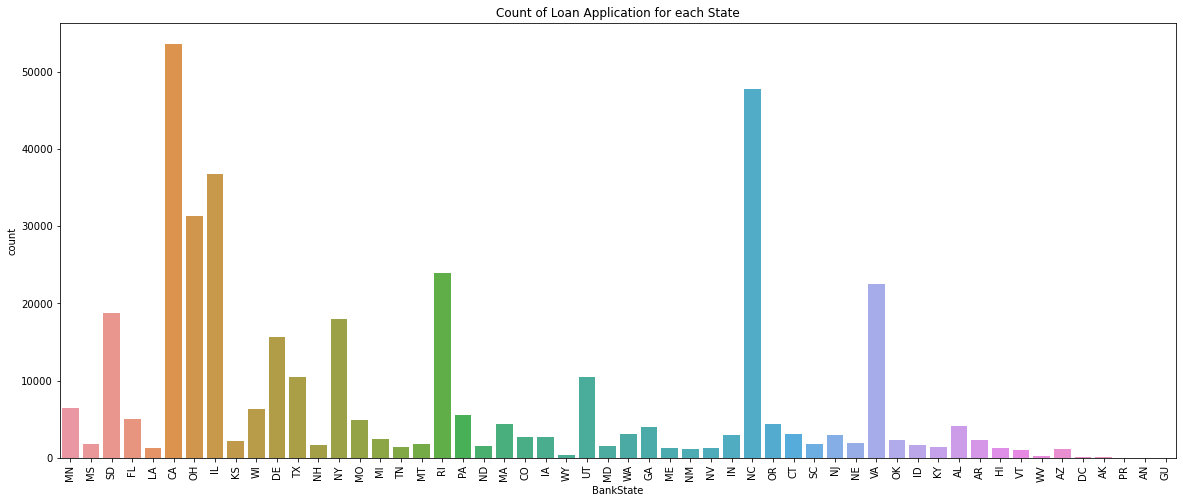

In [77]:
plt.figure(figsize=(20,8))
sns.countplot(df['BankState'])
plt.title('Count of Loan Application for each State')
plt.xticks(rotation=90)
plt.show()

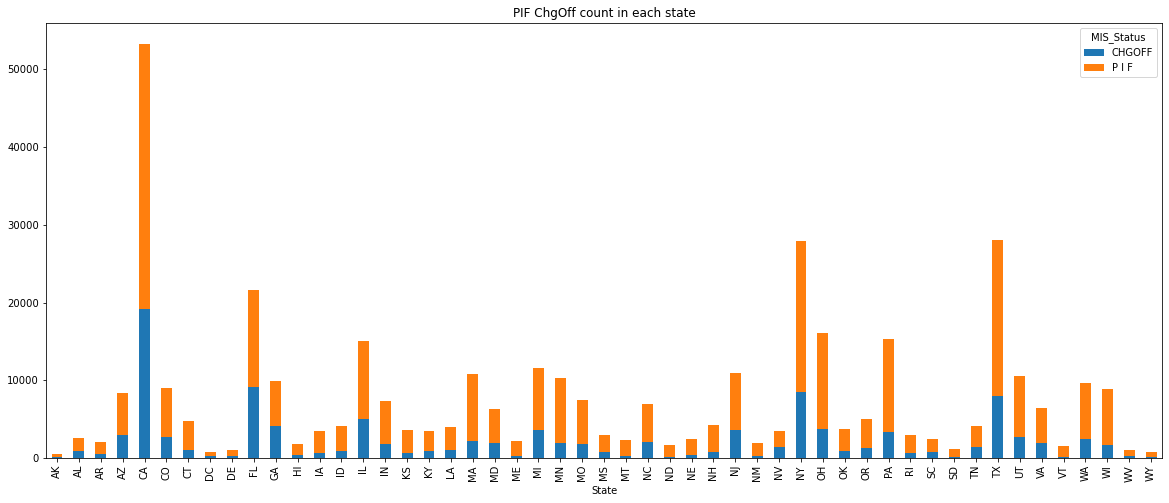

In [78]:
pd.crosstab(df['State'],df['MIS_Status']).plot(kind='bar',stacked=True,figsize=(20,8))
plt.title('PIF ChgOff count in each state')
plt.xticks(rotation=90)
plt.show()

* Count of PIF and Chgoff with respect each State.

In [79]:
df_new.head(2)

,Term,NoEmp,CreateJob,RetainedJob,GrAppv,SBA_Appv,Date_Diff,RealEstate,NAICS_21,NAICS_22,...,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NewExist_2.0,FranchiseCode_1,UrbanRural_2,LowDoc_1,MIS_Status_P I F,RevLineCr
0,162,2,0,0,253400.0,190050.0,52.0,0,0,0,...,0,0,0,0,1,1,0,0,1,N
1,126,7,0,0,137300.0,116705.0,82.0,0,0,0,...,0,0,1,0,0,0,0,0,1,N


In [80]:
df_new['MIS_Status_P I F'] = df_new['MIS_Status_P I F'].replace({1:0,0:1})
df_new = df_new.rename(columns={'MIS_Status_P I F':'MIS_Status'})
df_new['State'] = df['State']

In [81]:
df_new.head(2)

,Term,NoEmp,CreateJob,RetainedJob,GrAppv,SBA_Appv,Date_Diff,RealEstate,NAICS_21,NAICS_22,...,NAICS_71,NAICS_72,NAICS_81,NewExist_2.0,FranchiseCode_1,UrbanRural_2,LowDoc_1,MIS_Status,RevLineCr,State
0,162,2,0,0,253400.0,190050.0,52.0,0,0,0,...,0,0,0,1,1,0,0,0,N,NC
1,126,7,0,0,137300.0,116705.0,82.0,0,0,0,...,0,1,0,0,0,0,0,0,N,AR


#### Target Encoding

In [82]:
encoder = TargetEncoder()
df_new['State_encode'] = encoder.fit_transform(df_new['State'],df_new['MIS_Status'])
df_new.head(2)

,Term,NoEmp,CreateJob,RetainedJob,GrAppv,SBA_Appv,Date_Diff,RealEstate,NAICS_21,NAICS_22,...,NAICS_72,NAICS_81,NewExist_2.0,FranchiseCode_1,UrbanRural_2,LowDoc_1,MIS_Status,RevLineCr,State,State_encode
0,162,2,0,0,253400.0,190050.0,52.0,0,0,0,...,0,0,1,1,0,0,0,N,NC,0.305935
1,126,7,0,0,137300.0,116705.0,82.0,0,0,0,...,1,0,0,0,0,0,0,N,AR,0.259481


In [83]:
df_new = df_new.drop('State',1)

* As State has 51 unique values encoded the state with target by Target Encoding

* Dropped State  from dataset as we have new encoded feature

In [84]:
df_new = pd.get_dummies(df_new,drop_first=True)

In [85]:
df_new.to_csv('Cleaned_final_file.csv')

In [86]:
df_sc = df_new[['Term','GrAppv','SBA_Appv','Date_Diff','NoEmp','RetainedJob','CreateJob']]

df_res = df_new.drop(['Term','GrAppv','SBA_Appv','Date_Diff','NoEmp','RetainedJob','CreateJob'],1)

df_sc = df_sc.reset_index(drop=True)

df_res = df_res.reset_index(drop=True)

sc = StandardScaler()

df_sca = pd.DataFrame(sc.fit_transform(df_sc),columns=df_sc.columns)

df_scaled = pd.concat([df_sca,df_res],1)

df_scaled.shape

(385493, 33)

In [87]:
df_num=df_new[['Term','GrAppv','SBA_Appv','Date_Diff','NoEmp','RetainedJob','CreateJob']]

Q1 = df_num.quantile(0.25)

Q3 = df_num.quantile(0.75)

IQR = Q3 - Q1

df_outliers = df_new[~((df_new < (Q1 - 1.5 * IQR)) | (df_new > (Q3 + 1.5 * IQR))).any(axis=1)]


print('Shape of the data before handling outliers : ',df_new.shape)
print('\n')
print('Shape of the data after handling outliers : ',df_outliers.shape)

Shape of the data before handling outliers :  (385493, 33)


Shape of the data after handling outliers :  (243539, 33)


### Splitting the Data for Model Building

#### Original Data

In [88]:
X = df_new.drop('MIS_Status',1)
y = df_new['MIS_Status']

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

print('x train shape:',x_train.shape)
print('x test shape:',x_test.shape)
print('y train shape:',y_train.shape)
print('y test shape:',y_test.shape)

x train shape: (308394, 32)
x test shape: (77099, 32)
y train shape: (308394,)
y test shape: (77099,)


#### Scaled Data:

In [89]:
X_sc = df_scaled.drop('MIS_Status',1)
y_sc = df_scaled['MIS_Status']

x_train_sc,x_test_sc,y_train_sc,y_test_sc = train_test_split(X_sc,y_sc,test_size=0.2,random_state=10)

print('x train shape:',x_train_sc.shape)
print('x test shape:',x_test_sc.shape)
print('y train shape:',y_train_sc.shape)
print('y test shape:',y_test_sc.shape)

x train shape: (308394, 32)
x test shape: (77099, 32)
y train shape: (308394,)
y test shape: (77099,)


#### Outliers Treated Data:

In [90]:
X_ot = df_outliers.drop('MIS_Status',1)
y_ot = df_outliers['MIS_Status']

x_train_ot,x_test_ot,y_train_ot,y_test_ot = train_test_split(X_ot,y_ot,test_size=0.2,random_state=10)

print('x train shape:',x_train_ot.shape)
print('x test shape:',x_test_ot.shape)
print('y train shape:',y_train_ot.shape)
print('y test shape:',y_test_ot.shape)

x train shape: (194831, 32)
x test shape: (48708, 32)
y train shape: (194831,)
y test shape: (48708,)


# BASE MODEL

In [91]:
score_card = pd.DataFrame(columns=['Model_Name','Accuracy','F1_weighted','Precision','Recall'])

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall


#### LogisticRegression

In [92]:
Logistic = LogisticRegression(random_state=10)
model = Logistic.fit(x_train,y_train)
ypred_test = model.predict(x_test)
ypred_train = model.predict(x_train)
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

LogisticRegression(random_state=10)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      1.00      0.83    218766
           1       0.46      0.01      0.02     89628

    accuracy                           0.71    308394
   macro avg       0.58      0.50      0.42    308394
weighted avg       0.64      0.71      0.59    308394

Confusion Matrix
-------------------------------------------------
[[217780    986]
 [ 88794    834]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      1.00      0.83     54843
           1       0.48      0.01      0.02     22256

    accuracy                           0.71     77099
   macro avg       0.60      0.50      0.42     77099
weighted avg       0.65      0.71     

In [93]:
logistic = pd.Series({'Model_Name':'Logistic Regression',
                      'Accuracy':accuracy_score(y_test,ypred_test),
                      'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                      'Precision':precision_score(y_test,ypred_test),
                      'Recall':recall_score(y_test,ypred_test)
                               })

score_card=score_card.append(logistic,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615


#### DecisionTree

In [94]:
dt = DecisionTreeClassifier(random_state=10)
model_dt = dt.fit(x_train,y_train)
ypred_test = model_dt.predict(x_test)
ypred_train = model_dt.predict(x_train)
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

LogisticRegression(random_state=10)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    218766
           1       1.00      1.00      1.00     89628

    accuracy                           1.00    308394
   macro avg       1.00      1.00      1.00    308394
weighted avg       1.00      1.00      1.00    308394

Confusion Matrix
-------------------------------------------------
[[218766      0]
 [     8  89620]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     54843
           1       0.82      0.82      0.82     22256

    accuracy                           0.90     77099
   macro avg       0.87      0.88      0.88     77099
weighted avg       0.90      0.90     

In [95]:
tree = pd.Series({'Model_Name':'Decision Tree',
                   'Accuracy':accuracy_score(y_test,ypred_test),
                    'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test,ypred_test),
                    'Recall':recall_score(y_test,ypred_test)
                 })

score_card=score_card.append(tree,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868


#### KNN

In [96]:
knn = KNeighborsClassifier()
model = knn.fit(x_train_sc,y_train_sc)
ypred_test = model.predict(x_test_sc)
ypred_train = model.predict(x_train_sc)
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train_sc,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train_sc,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test_sc,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test_sc,ypred_test))

KNeighborsClassifier()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93    218766
           1       0.83      0.79      0.81     89628

    accuracy                           0.89    308394
   macro avg       0.87      0.86      0.87    308394
weighted avg       0.89      0.89      0.89    308394

Confusion Matrix
-------------------------------------------------
[[204436  14330]
 [ 18784  70844]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     54843
           1       0.75      0.71      0.73     22256

    accuracy                           0.85     77099
   macro avg       0.82      0.81      0.81     77099
weighted avg       0.85      0.85      0.85     770

In [97]:
knn_model = pd.Series({'Model_Name':'KNN',
                     'Accuracy':accuracy_score(y_test_sc,ypred_test),
                    'F1_weighted':f1_score(y_test_sc,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test_sc,ypred_test),
                    'Recall':recall_score(y_test_sc,ypred_test)
                               })

score_card=score_card.append(knn_model,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965


#### Gaussian Naive bayes

In [98]:
gb = GaussianNB()
model = gb.fit(x_train,y_train)
ypred_test = model.predict(x_test)
ypred_train = model.predict(x_train)
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')

GaussianNB()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.29      0.43    218766
           1       0.34      0.91      0.50     89628

    accuracy                           0.47    308394
   macro avg       0.61      0.60      0.47    308394
weighted avg       0.73      0.47      0.45    308394

Confusion Matrix
-------------------------------------------------
[[ 62881 155885]
 [  8164  81464]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.29      0.43     54843
           1       0.34      0.91      0.50     22256

    accuracy                           0.47     77099
   macro avg       0.61      0.60      0.46     77099
weighted avg       0.73      0.47      0.45     77099

Confus

In [99]:
gb_model = pd.Series({'Model_Name':'Gaussian Naive Bayes',
                    'Accuracy':accuracy_score(y_test_sc,ypred_test),
                    'F1_weighted':f1_score(y_test_sc,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test_sc,ypred_test),
                    'Recall':recall_score(y_test_sc,ypred_test)
                               })

score_card=score_card.append(gb_model,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755


#### Support vector Machine

### Feature Importance:

#### RFE:

In [100]:
lr = LogisticRegression()

rfe_model = RFECV(estimator=lr, min_features_to_select=1)


rfe_model = rfe_model.fit(x_train.values, y_train.values)
 
feat_index = pd.Series(data = rfe_model.ranking_, index = X.columns)

signi_feat_rfe = feat_index[feat_index==1].index

# print the significant features obtained from RFE
print(signi_feat_rfe)

Index(['Term', 'NoEmp', 'RealEstate', 'NAICS_31-33', 'NAICS_44-45',
       'NAICS_48-49', 'NAICS_53', 'NAICS_54', 'NAICS_56', 'NAICS_62',
       'NAICS_72', 'UrbanRural_2', 'LowDoc_1', 'State_encode', 'RevLineCr_Y'],
      dtype='object')


#### Output :

'Term', 'NoEmp', 'RealEstate', 'NAICS_31-33', 'NAICS_44-45',
       'NAICS_48-49', 'NAICS_53', 'NAICS_54', 'NAICS_56', 'NAICS_62',
       'NAICS_72', 'NewExist_2.0', 'UrbanRural_2', 'LowDoc_1', 'State_encode',
       'RevLineCr_Y'

In [101]:
dt = DecisionTreeClassifier()

rfe_model = RFECV(estimator=dt, min_features_to_select=1)


rfe_model = rfe_model.fit(x_train.values, y_train.values)
 
feat_index = pd.Series(data = rfe_model.ranking_, index = X.columns)

signi_feat_rfe = feat_index[feat_index==1].index

# print the significant features obtained from RFE
print(signi_feat_rfe)

Index(['Term'], dtype='object')


#### Output:

['Term']

#### Decision Tree Feature Importance:

In [102]:
important_features = pd.DataFrame({'Features':x_train.columns,'Importances':model_dt.feature_importances_*100})
important_features=important_features.sort_values(by='Importances',ascending=False)
important_features

,Features,Importances
0,Term,66.758992
6,Date_Diff,5.661828
30,State_encode,5.557797
4,GrAppv,5.204160
5,SBA_Appv,3.983881
1,NoEmp,2.226985
3,RetainedJob,2.127738
2,CreateJob,1.525227
31,RevLineCr_Y,1.249099
26,NewExist_2.0,0.589939


In [103]:
important_features[important_features['Importances']>1]['Features'].tolist()

['Term',
 'Date_Diff',
 'State_encode',
 'GrAppv',
 'SBA_Appv',
 'NoEmp',
 'RetainedJob',
 'CreateJob',
 'RevLineCr_Y']

#### KNN

### Significant Features Model:

#### Logistic Model with Significant Features:

In [104]:
Logistic_sig = LogisticRegression(random_state=10)
model = Logistic_sig.fit(x_train.drop(['CreateJob','RetainedJob','GrAppv','SBA_Appv','Date_Diff','FranchiseCode_1'],1),y_train)
ypred_test = model.predict(x_test.drop(['CreateJob','RetainedJob','GrAppv','SBA_Appv','Date_Diff','FranchiseCode_1'],1))
ypred_train = model.predict(x_train.drop(['CreateJob','RetainedJob','GrAppv','SBA_Appv','Date_Diff','FranchiseCode_1'],1))
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

LogisticRegression(random_state=10)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86    218766
           1       0.71      0.50      0.59     89628

    accuracy                           0.79    308394
   macro avg       0.76      0.71      0.73    308394
weighted avg       0.79      0.79      0.78    308394

Confusion Matrix
-------------------------------------------------
[[200038  18728]
 [ 44635  44993]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     54843
           1       0.70      0.50      0.59     22256

    accuracy                           0.79     77099
   macro avg       0.76      0.71      0.72     77099
weighted avg       0.79      0.79     

In [105]:
logistic_sig = pd.Series({'Model_Name':'Logistic Regression with Significant Features',
                      'Accuracy':accuracy_score(y_test,ypred_test),
                      'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                      'Precision':precision_score(y_test,ypred_test),
                      'Recall':recall_score(y_test,ypred_test)
                               })

score_card=score_card.append(logistic_sig,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755
4,Logistic Regression with Significant Features,0.794718,0.783479,0.700869,0.503954


#### Decision Tree with Significant Features:

In [106]:
dt_sig = DecisionTreeClassifier(random_state=10)
model = dt_sig.fit(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']],y_train)
ypred_test = model.predict(x_test[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
ypred_train = model.predict(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

DecisionTreeClassifier(random_state=10)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    218766
           1       1.00      1.00      1.00     89628

    accuracy                           1.00    308394
   macro avg       1.00      1.00      1.00    308394
weighted avg       1.00      1.00      1.00    308394

Confusion Matrix
-------------------------------------------------
[[218766      0]
 [    82  89546]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     54843
           1       0.82      0.82      0.82     22256

    accuracy                           0.89     77099
   macro avg       0.87      0.87      0.87     77099
weighted avg       0.89      0.89 

In [107]:
tree_sig = pd.Series({'Model_Name':'Decision Tree with significant features',
                   'Accuracy':accuracy_score(y_test,ypred_test),
                    'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test,ypred_test),
                    'Recall':recall_score(y_test,ypred_test)
                 })

score_card=score_card.append(tree_sig,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755
4,Logistic Regression with Significant Features,0.794718,0.783479,0.700869,0.503954
5,Decision Tree with significant features,0.894629,0.894618,0.817716,0.817128


#### KNN with significant features:

### HyperParameter Tuning

#### Tuning Logistic Model

#### Logistic Model Best parameters
-------------------------------------------------

#### Output:
    
{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 100, 'C': 11.288378916846883}

#### Tuning Decision Tree

#### Tuning KNN Model

### Tuned Models

#### Tuned Logistic Model

In [108]:
Logistic_tuned = LogisticRegression(solver='newton-cg',penalty='l2',max_iter=100,C=11.288378916846883,random_state=10)
model = Logistic_tuned.fit(x_train.drop(['CreateJob','RetainedJob','GrAppv','SBA_Appv','Date_Diff','FranchiseCode_1'],1),y_train)
ypred_test = model.predict(x_test.drop(['CreateJob','RetainedJob','GrAppv','SBA_Appv','Date_Diff','FranchiseCode_1'],1))
ypred_train = model.predict(x_train.drop(['CreateJob','RetainedJob','GrAppv','SBA_Appv','Date_Diff','FranchiseCode_1'],1))
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

LogisticRegression(C=11.288378916846883, random_state=10, solver='newton-cg')
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.87    218766
           1       0.71      0.52      0.60     89628

    accuracy                           0.80    308394
   macro avg       0.77      0.72      0.73    308394
weighted avg       0.79      0.80      0.79    308394

Confusion Matrix
-------------------------------------------------
[[199325  19441]
 [ 42773  46855]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     54843
           1       0.70      0.52      0.60     22256

    accuracy                           0.80     77099
   macro avg       0.76      0.72      0.73     77

In [109]:
logistic_tuned = pd.Series({'Model_Name':'Tuned Logistic Regression with Significant Features',
                      'Accuracy':accuracy_score(y_test,ypred_test),
                      'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                      'Precision':precision_score(y_test,ypred_test),
                      'Recall':recall_score(y_test,ypred_test)
                               })

score_card=score_card.append(logistic_tuned,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755
4,Logistic Regression with Significant Features,0.794718,0.783479,0.700869,0.503954
5,Decision Tree with significant features,0.894629,0.894618,0.817716,0.817128
6,Tuned Logistic Regression with Significant Fea...,0.797313,0.787691,0.698771,0.523544


#### Tuned Decision Tree

In [110]:
dt_sig = DecisionTreeClassifier(max_depth=8,criterion='gini',random_state=10)
model = dt_sig.fit(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']],y_train)
ypred_test = model.predict(x_test[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
ypred_train = model.predict(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

DecisionTreeClassifier(max_depth=8, random_state=10)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    218766
           1       0.85      0.86      0.86     89628

    accuracy                           0.92    308394
   macro avg       0.90      0.90      0.90    308394
weighted avg       0.92      0.92      0.92    308394

Confusion Matrix
-------------------------------------------------
[[205475  13291]
 [ 12735  76893]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     54843
           1       0.85      0.85      0.85     22256

    accuracy                           0.91     77099
   macro avg       0.89      0.90      0.90     77099
weighted avg       0.

In [111]:
tree_tuned = pd.Series({'Model_Name':'Tuned Decision Tree with significant features',
                   'Accuracy':accuracy_score(y_test,ypred_test),
                    'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test,ypred_test),
                    'Recall':recall_score(y_test,ypred_test)
                 })

score_card=score_card.append(tree_tuned,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755
4,Logistic Regression with Significant Features,0.794718,0.783479,0.700869,0.503954
5,Decision Tree with significant features,0.894629,0.894618,0.817716,0.817128
6,Tuned Logistic Regression with Significant Fea...,0.797313,0.787691,0.698771,0.523544
7,Tuned Decision Tree with significant features,0.913643,0.913705,0.848730,0.852849


#### Tuned KNN Model

### Ensemble Models

### RandomForest 

In [112]:
rf = RandomForestClassifier()
model = rf.fit(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']],y_train)
ypred_test = model.predict(x_test[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
ypred_train = model.predict(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

RandomForestClassifier()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    218766
           1       1.00      1.00      1.00     89628

    accuracy                           1.00    308394
   macro avg       1.00      1.00      1.00    308394
weighted avg       1.00      1.00      1.00    308394

Confusion Matrix
-------------------------------------------------
[[218751     15]
 [    68  89560]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     54843
           1       0.88      0.87      0.87     22256

    accuracy                           0.93     77099
   macro avg       0.91      0.91      0.91     77099
weighted avg       0.93      0.93      0.93     7

In [113]:
rf_model = pd.Series({'Model_Name':'RandomForest with significant features',
                   'Accuracy':accuracy_score(y_test,ypred_test),
                    'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test,ypred_test),
                    'Recall':recall_score(y_test,ypred_test)
                 })

score_card=score_card.append(rf_model,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755
4,Logistic Regression with Significant Features,0.794718,0.783479,0.700869,0.503954
5,Decision Tree with significant features,0.894629,0.894618,0.817716,0.817128
6,Tuned Logistic Regression with Significant Fea...,0.797313,0.787691,0.698771,0.523544
7,Tuned Decision Tree with significant features,0.913643,0.913705,0.848730,0.852849
8,RandomForest with significant features,0.928131,0.928010,0.879800,0.869878


#### Ada Boost

In [114]:
ada = AdaBoostClassifier()
model = ada.fit(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']],y_train)
ypred_test = model.predict(x_test[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
ypred_train = model.predict(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

AdaBoostClassifier()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    218766
           1       0.80      0.83      0.81     89628

    accuracy                           0.89    308394
   macro avg       0.87      0.87      0.87    308394
weighted avg       0.89      0.89      0.89    308394

Confusion Matrix
-------------------------------------------------
[[200471  18295]
 [ 15466  74162]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     54843
           1       0.80      0.83      0.81     22256

    accuracy                           0.89     77099
   macro avg       0.86      0.87      0.87     77099
weighted avg       0.89      0.89      0.89     77099

In [115]:
ada_model = pd.Series({'Model_Name':'AdaBoosting with significant features',
                   'Accuracy':accuracy_score(y_test,ypred_test),
                    'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test,ypred_test),
                    'Recall':recall_score(y_test,ypred_test)
                 })

score_card=score_card.append(ada_model,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755
4,Logistic Regression with Significant Features,0.794718,0.783479,0.700869,0.503954
5,Decision Tree with significant features,0.894629,0.894618,0.817716,0.817128
6,Tuned Logistic Regression with Significant Fea...,0.797313,0.787691,0.698771,0.523544
7,Tuned Decision Tree with significant features,0.913643,0.913705,0.848730,0.852849
8,RandomForest with significant features,0.928131,0.928010,0.879800,0.869878
9,AdaBoosting with significant features,0.890440,0.890989,0.799766,0.827687


#### Gradient Boosting

In [116]:
gd = GradientBoostingClassifier()
model = gd.fit(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']],y_train)
ypred_test = model.predict(x_test[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
ypred_train = model.predict(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

GradientBoostingClassifier()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    218766
           1       0.86      0.85      0.85     89628

    accuracy                           0.92    308394
   macro avg       0.90      0.90      0.90    308394
weighted avg       0.92      0.92      0.92    308394

Confusion Matrix
-------------------------------------------------
[[206465  12301]
 [ 13779  75849]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     54843
           1       0.86      0.85      0.85     22256

    accuracy                           0.92     77099
   macro avg       0.90      0.90      0.90     77099
weighted avg       0.91      0.92      0.91  

In [117]:
gd_model = pd.Series({'Model_Name':'Gradient Boosting with significant features',
                   'Accuracy':accuracy_score(y_test,ypred_test),
                    'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test,ypred_test),
                    'Recall':recall_score(y_test,ypred_test)
                 })

score_card=score_card.append(gd_model,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755
4,Logistic Regression with Significant Features,0.794718,0.783479,0.700869,0.503954
5,Decision Tree with significant features,0.894629,0.894618,0.817716,0.817128
6,Tuned Logistic Regression with Significant Fea...,0.797313,0.787691,0.698771,0.523544
7,Tuned Decision Tree with significant features,0.913643,0.913705,0.848730,0.852849
8,RandomForest with significant features,0.928131,0.928010,0.879800,0.869878
9,AdaBoosting with significant features,0.890440,0.890989,0.799766,0.827687


#### XGBoost

In [118]:
xb = XGBClassifier()
model = xb.fit(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']],y_train)
ypred_test = model.predict(x_test[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
ypred_train = model.predict(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

[18:25:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
-------------------------------------------------
Classification Report for Train Data
---------------------

In [119]:
xb_model = pd.Series({'Model_Name':'XGBoost with significant features',
                   'Accuracy':accuracy_score(y_test,ypred_test),
                    'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test,ypred_test),
                    'Recall':recall_score(y_test,ypred_test)
                 })

score_card=score_card.append(xb_model,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755
4,Logistic Regression with Significant Features,0.794718,0.783479,0.700869,0.503954
5,Decision Tree with significant features,0.894629,0.894618,0.817716,0.817128
6,Tuned Logistic Regression with Significant Fea...,0.797313,0.787691,0.698771,0.523544
7,Tuned Decision Tree with significant features,0.913643,0.913705,0.848730,0.852849
8,RandomForest with significant features,0.928131,0.928010,0.879800,0.869878
9,AdaBoosting with significant features,0.890440,0.890989,0.799766,0.827687


### Tuning Random Forest Model:

#### Output :

Random Forest Best parameters
-------------------------------------------------
{'n_estimators': 50, 'max_depth': 7, 'criterion': 'entropy'}

### Tuned Random Forest 

In [120]:
rf = RandomForestClassifier(n_estimators=50,max_depth=7,criterion='entropy')
model = rf.fit(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']],y_train)
ypred_test = model.predict(x_test[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
ypred_train = model.predict(x_train[['Term','Date_Diff','State_encode','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,ypred_test))

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=50)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    218766
           1       0.80      0.82      0.81     89628

    accuracy                           0.89    308394
   macro avg       0.86      0.87      0.87    308394
weighted avg       0.89      0.89      0.89    308394

Confusion Matrix
-------------------------------------------------
[[200375  18391]
 [ 16021  73607]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     54843
           1       0.80      0.82      0.81     22256

    accuracy                           0.89     77099
   macro avg       0.86      0.87      0.86     77099


In [121]:
rf_tuned = pd.Series({'Model_Name':'Tuned RandomForest with significant features',
                   'Accuracy':accuracy_score(y_test,ypred_test),
                    'F1_weighted':f1_score(y_test,ypred_test,average='weighted'),
                    'Precision':precision_score(y_test,ypred_test),
                    'Recall':recall_score(y_test,ypred_test)
                 })

score_card=score_card.append(rf_tuned,ignore_index=True)

score_card

,Model_Name,Accuracy,F1_weighted,Precision,Recall
0,Logistic Regression,0.711125,0.596296,0.481982,0.009615
1,Decision Tree,0.897457,0.897502,0.821432,0.823868
2,KNN,0.849894,0.848673,0.753188,0.713965
3,Gaussian Naive Bayes,0.466712,0.451977,0.340887,0.907755
4,Logistic Regression with Significant Features,0.794718,0.783479,0.700869,0.503954
5,Decision Tree with significant features,0.894629,0.894618,0.817716,0.817128
6,Tuned Logistic Regression with Significant Fea...,0.797313,0.787691,0.698771,0.523544
7,Tuned Decision Tree with significant features,0.913643,0.913705,0.848730,0.852849
8,RandomForest with significant features,0.928131,0.928010,0.879800,0.869878
9,AdaBoosting with significant features,0.890440,0.890989,0.799766,0.827687


## CONCLUSION:

### Performance of various models are recorded above.

### XGBoost is giving us the best results out of all the models.

### With 93% Accuracy and Recall 89%

#### We will be performing SMOTE analysis as we have imbalance in the Target column and check for the results.

In [122]:
sm = SMOTE(random_state=42, sampling_strategy=1.0, k_neighbors=5)
Xsmot_train, ysmot_train = sm.fit_resample(x_train[['Term','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob',
                                                    'RevLineCr_Y']],y_train)

In [123]:
# Best Gradient Boost Hyperparameter Tuning
xb_smot = XGBClassifier(random_state= 2021)
xb_smot.fit(Xsmot_train, ysmot_train)
xb_smot_pred_train = xb_smot.predict(x_train[['Term','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])
xb_smot_pred_test = xb_smot.predict(x_test[['Term','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])

print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train,xb_smot_pred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train,xb_smot_pred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test,xb_smot_pred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test,xb_smot_pred_test))

[18:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=50)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.93      0.95    218766
           1       0.84      0.93      0.88     89628

    accuracy                           0.93    308394
   macro avg       0.90      0.93      0.91    308394
weighted avg       0.93      0.93      0.93    308394

Confusion Matrix
-------------------------------------------------
[[202592  16174]
 [  6355  83273]]


Classification Report For Test Data
------------

In [124]:
print('The distribution of target before applying SMOTE :', Counter(y_train))
print('\n')
print('The distribution of target after applying SMOTE :', Counter(ysmot_train))
print('\n')

The distribution of target before applying SMOTE : Counter({0: 218766, 1: 89628})


The distribution of target after applying SMOTE : Counter({1: 218766, 0: 218766})




### ROC AUC:

In [125]:
ypred_proba = xb_smot.predict_proba(x_test[['Term','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])

ypred = xb_smot.predict(x_test[['Term','GrAppv','SBA_Appv','NoEmp','RetainedJob','CreateJob','RevLineCr_Y']])

fpr , tpr , th = roc_curve(y_test,ypred_proba[:,1])

score = roc_auc_score(y_test,ypred)

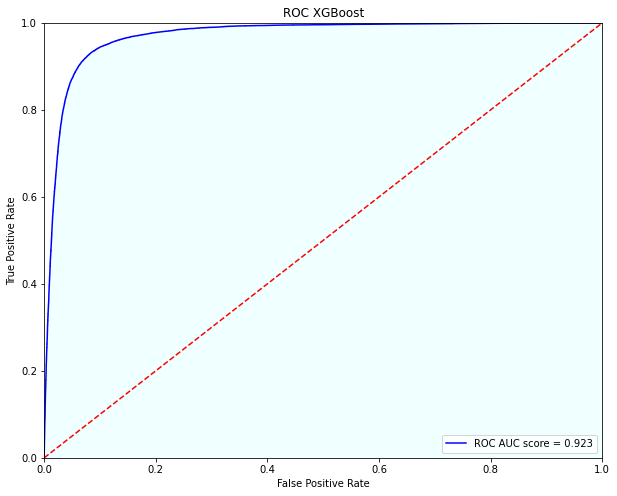

In [126]:
plt.figure(figsize=(10,8))
plt.title('ROC XGBoost')
plt.plot(fpr, tpr, 'blue', label='ROC AUC score = {}'.format(round(score,3)))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr, tpr, 0, facecolor='azure', alpha=1)
plt.legend(loc='lower right')
plt.show()

# XGBoost after applying SMOTE analysis is our final model with 92% Accuracy and 92% of Recall.